# Goal of this Project
An important resource lawyers and judges utilize when analyzing case law is headnotes. Headnotes are brief case summary statements often generated by commercial third parties. They are under copyright protection, and so are not always available or are subject to many usage restrictions. Headnotes are especially useful since case law can be long, thus making it difficult to quickly understand what the case's facts and findings are. 

The goal of this project is to reconstruct headnotes for a variety of cases, using historical court cases from North Carolina as a training set. We will use the Caselaw Access Project, a recently-released dataset of all United States case law from the Harvard Law School Library.

# Literature Review
The area of Natural Language Processing (NLP) has become increasing important in recent years. With popular sites like Twitter, Reddit, and Quora, just to name a few, there is a plethora of writing on the internet. With so much written language being shared each day on the internet, it is important that we have a mechanism for analyzing it. And luckily, NLP methods in data science are better than ever. 

Research on NLP has greatly expanded within the past 70 years, with research into NLP beginning as early as the 1950s. By the mid 1950s machines were able to translate Russian into English, by the 1960s the first interactive machines were developed to communicate with people, and in the present day, we now have pretrained models that can do summarize texts, generate new sentences, and respond to novel questions.

Summarization, in particular, is incredibly useful given the wide variety of tasks it can perform. Summarization techniques are used to generate headlines, outlines, minutes for a meeting, movie previews, abridgements of long or difficult texts, and bulletins, just to name a few. Approaches to summarization can also vary depending on the goal.

For the purposes of this project, we decided to research the different kinds of outputs our summarization would produce. Summarization techniques concerning output can broken down into two groups: extractive and abstractive. Extractive summarization refers to *extracting* the most important sentences from the original text to generate the summary. Abstractive summarization, on the other hand, involves the model interpreting and analyzing the text utilizing advanced natural language techniques and being able to generate novel words or sentences to convey the original meaning of the text and summarize. Abstractive summarization is the more advanced technique and most similar to how humans would summarize a given text, but research has shown that extractive methods are often more reliable and provide better results, as abstractive summarization is more prone to generating gibberish. 

Within extractive summarization, there are two major types of representation approaches: topic representation and indicator representation. As the names indicate, topic representation works by understanding the topics discussed in the text while the indicator representation describes each sentence as a list of features (indicators) like sentence length, certain phrases, etc. Based on these representations of text, a score is assigned to each sentence. In topic representation, the score indicates how well the sentences describe the topic. In indicator representation, the score is calculated by aggregating the weighted features in the sentence. The third step in extractive summarization is selecting the top *k* sentences to use as the summary, based on the score previously calculated. Topic representations include approaches like topic words, frequency driven approaches, and latent semantic analysis, to name a few. Indicator representations include approaches like graph methods (TextRank, PageRank) and machine learning. 

Within abstractive summarization, there are two major types of approaches: structure-based and semantic-based. Structured-based summarization utilizes prior knowledge about the text and its structure, as well as linguistic templates, to form a summary. Semantic-based summarization, on the other hand, attempts to understand the language and words themselves to feed into a natural language generation system that focuses on identifying noun and verb phrases. Structure-based summarizations include approaches like tree-based models, template-based methods, and graph-based methods, while semantic-based summarizations include approaches like multimodal semantic models, and information item based methods. Important abstractive techniques that we decided to use in our project included seq-2-seq with attention, pointer-generator, and BERT (note that BERT is not designed to generate text, however). 
### Works Cited
https://medium.com/sciforce/towards-automatic-text-summarization-extractive-methods-e8439cd54715

https://medium.com/sciforce/towards-automatic-summarization-part-2-abstractive-methods-c424386a65ea

Prof. Chris Tanner: *A Brief Primer on NLP* powerpoint presentation


# Preparing for the Project
Due to the size of the data set, we ran our project in Google Colab because it allowed us to train our models quickly. In order to access the data, navigate to https://case.law/bulk/download/ and download the North Carolina text file. Our group uploaded data and helper functions into a shared Google Drive folder.

Once we did this, we proceeded to mount our Google drives and run in Google Colab as demonstrated below. More detailed notes about utilizing pretrained models, as in BERT for example, are discussed later on in the notebook.


# Imports
We will import lzma and json in order to read the data, nltk to engage in nlp analysis, tensorflow, and a variety of common libraries are used for I/O, image and data processing, and visualization.

In [0]:
import lzma, json
from nltk.tokenize import PunktSentenceTokenizer
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from bs4 import BeautifulSoup
import tensorflow as tf
import os
import re
import spacy
from spacy.lang.en import English
from nltk.corpus import wordnet as wn
import gensim
from gensim import corpora
#!pip install pyLDAvis
import pyLDAvis.gensim
import pickle
from nltk.cluster.util import cosine_distance
import networkx as nx
from tensorflow.python.keras.layers import Layer
from tensorflow.python.keras import backend as K
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords   
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

get_ipython().run_line_magic('config', "InlineBackend.figure_format = 'retina'")
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk import ngrams, FreqDist
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('wordnet')
import cufflinks as cf
from plotly.offline import iplot
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Definitions

In [0]:
def clean_words(fname):
  '''
  To do: 
  Cleans texts for EDA. Cleans the text by doing the following:
  # make everything lowercase
  # Remove HTML tags
  # Remove (‘s)
  # Remove any text inside the parenthesis ( )
  #  Eliminate punctuations and special characters
  # Remove stopwords
  # Remove short words

  Arg:
    - text: case law text
  Returns:
    - list of lists of word strings
  '''
  texts = fname
  texts = texts.rstrip()
  texts = texts.lower()
  texts = BeautifulSoup(texts, "lxml").text
  texts = re.sub(r'\([^)]*\)', '', texts)
  texts = re.sub('"','', texts)   
  texts = re.sub(r"'s\b","",texts)
  texts = re.sub("[^a-zA-Z]", " ", texts) 
  words = texts.split()
  stop_words = set(stopwords.words('english'))
  words_clean = [w for w in words if not w in stop_words]
  long_words=[]
  for i in words_clean:
    if len(i)>=4:
      long_words.append(i)
  return long_words

In [0]:
stop_words = set(stopwords.words('english')) 

def text_cleaner(text):
  '''
  To do:
  Helper function for similarity pipeline:
  cleans the text by doing the following
  # make everything lowercase
  # Remove HTML tags
  # Remove (‘s)
  # Remove any text inside the parenthesis ( )
  #  Eliminate punctuations and special characters
  # Remove stopwords
  # Remove short words

  Arg: 
    - text: case law text
  Returns:
    - Cleaned version of the text
  
  '''
  newString = text.lower()
  newString = BeautifulSoup(newString, "lxml").text
  newString = re.sub(r'\([^)]*\)', '', newString)
  newString = re.sub('"','', newString)   
  newString = re.sub(r"'s\b","",newString)
  newString = re.sub("[^a-zA-Z]", " ", newString) 
  tokens = [w for w in newString.split() if not w in stop_words]
  long_words=[]
  for i in tokens:
      if len(i)>=3:                  #removing short word
          long_words.append(i)   
  return (" ".join(long_words)).strip()


In [0]:
def read_article(file_name):
  '''
  Helper function for similarity pipeline:
  To do:
  Reads in a case law text and transforms each sentence in the text into a list of tokenized words

  Arg:
    - file_name: File name of the text (in our case will be a particular case file text from the case law data frame)
  Returns:
   - List of lists that contain tokenized words for each sentence in the text
  '''
  article = re.sub(r"(?<= [.(a-zA-z]{3})\.(?!=(\n))", ' ', file_name)
  article = re.sub(r"(?<= [a-zA-z]{2})\.(?!=(\n))", ' ', file_name)
  article_new = sent_tokenize(article)
  sentences = []
  for sentence in article_new:
    sentences.append(sentence.replace("[^a-zA-Z]", " ").split(" "))
  sentences.pop() 
  return sentences

In [0]:
def sentence_similarity(sent1, sent2, stopwords=None):
  '''
  Helper function for similarity pipeline:
  To do:
  Calculate the similarity between two sentences in a text in order to later calculate a similarity matrix for all of the sentences in the text.
  Calculates similarity through cosine similarity. Cosine similarity is a measure of similarity between two non-zero vectors of an inner product
    space that measures the cosine of the angle between them. Since we will be representing our sentences as the bunch of vectors, we can use it to
    find the similarity among sentences. Its measures cosine of the angle between vectors. Angle will be 0 if sentences are similar.
  
  Args:
    - Two sentences (sent1 and sent2) that will be the two sentences being compared
    - stopwords = False: set stop words to None so that if there are no stop words, the function creates an empty list of stop words so that the model can still run
  Returns: 
    - Similarity between two sentences in a text 

  '''
  if stopwords is None:
    stopwords = []
 
  sent1 = [w.lower() for w in sent1]
  sent2 = [w.lower() for w in sent2]
 
  all_words = list(set(sent1 + sent2))
 
  vector1 = [0] * len(all_words)
  vector2 = [0] * len(all_words)
 
  # build the vector for the first sentence
  for w in sent1:
    if w in stopwords:
      continue
    vector1[all_words.index(w)] += 1
 
  # build the vector for the second sentence
  for w in sent2:
    if w in stopwords:
      continue
    vector2[all_words.index(w)] += 1
  return 1 - cosine_distance(vector1, vector2)


In [0]:
def build_similarity_matrix(sentences, stop_words):
  '''
  Helper function for similarity pipeline:
  To do: Calculates the sentence similarity between each sentence pair in the text to create a similarity matrix for a text

  Args:
    - sentences: List of lists that contain tokenized words for each sentence in the text of interest
    - stop_words: set of stop words from nltk corpus to be used in the similarity pipeline
  '''
  # Create an empty similarity matrix
  similarity_matrix = np.zeros((len(sentences), len(sentences)))
 
  for idx1 in range(len(sentences)):
    for idx2 in range(len(sentences)):
      if idx1 == idx2: #ignore if both are same sentences
          continue 
      similarity_matrix[idx1][idx2] = sentence_similarity(sentences[idx1], sentences[idx2], stop_words)
  return similarity_matrix


In [0]:
def generate_summary(file_name, top_n=5):
  '''
  Function that calls helper functions defined above to create our summarization pipeline.
  Will take in a case law text and summarize it into top_n number of sentences
  Args:
    - file_name: Case law text we are interested in summarizing 
    - top_n: Number of sentences to be returned for summarization
  Returns:
    - Top n ranked sentences of the text

  '''
  stop_words = stopwords.words('english')
  summarize_text = []
  # Step 1 - Read text and tokenize
  sentences =  read_article(file_name)
  # Step 2 - Generate Similary Martix across sentences
  sentence_similarity_martix = build_similarity_matrix(sentences, stop_words)
  # Step 3 - Rank sentences in similarity martix
  sentence_similarity_graph = nx.from_numpy_array(sentence_similarity_martix)
  scores = nx.pagerank(sentence_similarity_graph)
  # Step 4 - Sort the rank and pick top sentences
  ranked_sentence = sorted(((scores[i],s) for i,s in enumerate(sentences)), reverse=True)    
  print("Indexes of top ranked_sentence order are ", ranked_sentence)
  for i in range(top_n):
    summarize_text.append(" ".join(ranked_sentence[i][1]))
    # Step 5 - Offcourse, output the summarize texr
    print("Summarize Text: \n", ". ".join(summarize_text))

## Preprocessing of Data

The data we are using comes from the Caselaw Access Project. We are using North Carolina due to its large data set and its inclusion of headnotes, which were accessed with permission from the state. The data set contains a dictionary of dictionaries that categorize different variables of interest about each piece of caselaw. There are 17 general attributes, but below are the ones of relevance:
* `id`: ID number of case
*`name`: Name of the case in question (ex. The State v. John Smith)
* `name_abbreviation`: Abbreviation of case in question (ex. State v. Smith)
* `decision_date`: Date that the court came to a decision about the case
*`docket_number`: How the court identifies each case. Included in the numbers are codes telling the judges, clerks, and lawyers when the case was filed and what type of case it is.
* `first_page`: First page where the case can be found in the reporter 
*`last_page`: Last page where the case can be found in the reporter
* `citations`: Citation of where case was found in the reporter
* `volume`: Volume number of the reporter
*`reporter`: Book that contains the judicial opinion from the case 
*`court`: What court resided over the cases
*`jurisdiction`: State that the case was heard
*`casebody`: Contains attorneys, judges, head matter of the case, and full list of judicial opinions

The attribute that we care the most about is `casebody` as it contains the case law text, as well as the head matter. As a preprocessing step, we will eliminate columns that are not necessary and add columns such as the head matter and majority opinion text. For example, we don't need a jurisdiction column since all of our cases are in North Carolina and having it in our data set doesn't affect how well our model summarizes the case texts.

In [0]:
# only need to run once
# lets you use the data in Google Drive folder I shared before (CS109b Final Project)
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# load North Carolina data
# note that we ran our data using Google Colab 
# saved our data in a drive and accessed our data through there
cases_nc = []
with lzma.open('/content/drive/My Drive/CS109b Final Project/data.jsonl.xz') as in_file:
    for line in in_file:
        case = json.loads(str(line, 'utf8'))
        cases_nc.append(case)

In [0]:
case_df = pd.DataFrame(cases_nc)

In [0]:
# one index don't exist (11376), so need to reset index
case_df= case_df.reset_index(drop=True)

In [0]:
# access actual casebody texts to save to data frame
case_df['data'] = case_df['casebody'].apply(lambda x: x['data'])
case_df['opinions'] = case_df['data'].apply(lambda x: x['opinions'])

In [0]:
# unnecessary but interesting
# some cases have multiple Opinions (majority, dissenting, etc)
# so I made a column in the dataset indicating how many opinions were on the case
lengths = []
for i in range(len(case_df['opinions'])):
  lengths.append(len(case_df['opinions'][i]))
case_df['num_opinions'] = lengths

In [0]:
# clean the appearance of the dataframe to get rid of as many dictionaries as possible
case_df['data'] = case_df['casebody'].apply(lambda x: x['data'])
case_df['court_name'] = case_df['court'].apply(lambda x: x['name'])
case_df['volume_no'] = case_df['volume'].apply(lambda x: x['volume_number'])
case_df['reporters'] = case_df['reporter'].apply(lambda x: x['full_name'])
case_df['reporter_url'] =case_df['reporter'].apply(lambda x: x['url'])
case_df['head_matter'] = case_df['data'].apply(lambda x: x['head_matter'])
case_df['citation'] = case_df['citations'].apply(lambda x: x[0]['cite'])
# DROP \n tag from head_matter
case_df['head_matter'] = case_df['head_matter'].replace('\n','', regex = True)

In [0]:
# drop unnecessary columns to clean appearance of data set
case_df = case_df.drop(columns = ['data', 'citations','casebody', 'preview', 'jurisdiction', 'volume', 'court', 'reporter', 'cites_to', 'frontend_url', 'reporter_url', 'first_page', 'last_page'])
case_df.head()

,id,url,name,name_abbreviation,decision_date,docket_number,opinions,num_opinions,court_name,volume_no,reporters,head_matter,citation
0,1268383,https://api.capapi.org/v1/cases/1268383/,The State vs. John Owen,State v. Owen,1810-07,,"[{'type': 'majority', 'text': 'A majority of the court, therefore, being of the latter opinion, the bill of indictment was pronounced exceptionable: consequently, upon it sentence of death cannot ...",1,Supreme Court of North Carolina,2,Wheeler's Criminal Cases,"SUPREME COURT,RALEIGH, (N. C.)JULY, 1810.The State vs. John Owen.Murder.In an indictment for murder the length and depth of the wound must be expressed. 2 Hawk. b. 2, c. 33, § 81. 2 Chitty’s C. L....",2 Wheel. Cr. Cas. 260
1,11956941,https://api.capapi.org/v1/cases/11956941/,DUNLOP et al. v. WEST,Dunlop v. West,1805,"Case No. 4,170","[{'type': 'majority', 'text': 'PER CURIAM. If the sheriff or marshal seizes property in execution, and neglects to sell it, and is sued for his neglect, the plaintiff-shall recover damages to the ...",1,United States Circuit Court for the District of North Carolina,8,Federal Cases,"Case No. 4,170.DUNLOP et al. v. WEST.[Brunner, Col. Cas. 27;2 Hayw. N. C. 346.]Circuit Court, D. North Carolina.1805.1[Reported by Albert Brunner, Esq., and here reprinted by permission.]",8 F. Cas. 93
2,11645357,https://api.capapi.org/v1/cases/11645357/,The FORTUNA,The Fortuna,1815,"Case No. 4,954","[{'type': 'majority', 'text': 'MARSHALL. Circuit Justice. The Fortuna, a vessel sailing under Russian colors, was captured on a voyage from the Havanna to some port in Europe, by the American priv...",1,United States Circuit Court for the District of North Carolina,9,Federal Cases,"Case No. 4,954.The FORTUNA.[1 Brock. 299.]Circuit Court, D. North Carolina.Spring Term, 1815.1[Reported by John W. Brockenbrough. Esq.]2[Affirmed in 3 Wheat. 16 U. S.) 236.]",9 F. Cas. 494
3,11272108,https://api.capapi.org/v1/cases/11272108/,D. K. FUTCH v. ATLANTIC COAST LINE RAILROAD COMPANY,Futch v. Atlantic Coast Line Railroad,1919-10-15,,"[{'type': 'majority', 'text': 'Walker, J. The grievance alleged by the plaintiff is that the defendant failed to place a refrigerating car for him at Wrightsboro by 2 :30 o’clock p. m. on 16 Hay, ...",1,Supreme Court of North Carolina,178,North Carolina Reports,"D. K. FUTCH v. ATLANTIC COAST LINE RAILROAD COMPANY.(Filed 15 October, 1919.)1. Carriers of Goods — Placing of Cars — Understanding of Agent — Instructions — Railroads.Where damages are sought to ...",178 N.C. 282
4,11273534,https://api.capapi.org/v1/cases/11273534/,"MRS. SUSANNA WILLIAMS v. C. G. BAILEY, B. R. BAILEY et al., Executors of W. R. BAILEY",Williams v. Bailey,1919-12-03,,"[{'type': 'majority', 'text': 'Hoke, J. On the hearing it appeared that C. G. Bailey and others, executors of the last will and testament of W. A. Bailey, deceased, intended presently to make sale...",1,Supreme Court of North Carolina,178,North Carolina Reports,"MRS. SUSANNA WILLIAMS v. C. G. BAILEY, B. R. BAILEY et al., Executors of W. R. BAILEY.(Filed 3 December, 1919.)1. Deeds and Conveyances — Descriptions—Reference to Other Instruments— Wills.Where a...",178 N.C. 630


In [0]:
# get majority opinion text
# some cases do not have any opinions, so if they do not have an opinion, append ''
# we will later drop those cases
texts = []
for i in range(len(case_df.opinions)):
  if case_df.opinions[i] == []:
    texts.append('')
  else:
   texts.append(case_df.opinions[i][0]['text'])

In [0]:
# add text majority to data set
# clean the text of \n tags
case_df['text_majority']  = [x.replace('\n', '') for x in texts]

In [0]:
#drop cases that do not have a text 
case_text_df = case_df[case_df.text_majority != '']

In [0]:
case_text_df_new = case_text_df.reset_index(drop = True)
case_text_df_new.head()

,id,url,name,name_abbreviation,decision_date,docket_number,opinions,num_opinions,court_name,volume_no,reporters,head_matter,citation,text_majority
0,1268383,https://api.capapi.org/v1/cases/1268383/,The State vs. John Owen,State v. Owen,1810-07,,"[{'type': 'majority', 'text': 'A majority of the court, therefore, being of the latter opinion, the bill of indictment was pronounced exceptionable: consequently, upon it sentence of death cannot ...",1,Supreme Court of North Carolina,2,Wheeler's Criminal Cases,"SUPREME COURT,RALEIGH, (N. C.)JULY, 1810.The State vs. John Owen.Murder.In an indictment for murder the length and depth of the wound must be expressed. 2 Hawk. b. 2, c. 33, § 81. 2 Chitty’s C. L....",2 Wheel. Cr. Cas. 260,"A majority of the court, therefore, being of the latter opinion, the bill of indictment was pronounced exceptionable: consequently, upon it sentence of death cannot bo passed , . 1 upon the prison..."
1,11956941,https://api.capapi.org/v1/cases/11956941/,DUNLOP et al. v. WEST,Dunlop v. West,1805,"Case No. 4,170","[{'type': 'majority', 'text': 'PER CURIAM. If the sheriff or marshal seizes property in execution, and neglects to sell it, and is sued for his neglect, the plaintiff-shall recover damages to the ...",1,United States Circuit Court for the District of North Carolina,8,Federal Cases,"Case No. 4,170.DUNLOP et al. v. WEST.[Brunner, Col. Cas. 27;2 Hayw. N. C. 346.]Circuit Court, D. North Carolina.1805.1[Reported by Albert Brunner, Esq., and here reprinted by permission.]",8 F. Cas. 93,"PER CURIAM.If the sheriff or marshal seizes property in execution, and neglects to sell it, and is sued for his neglect, the plaintiff-shall recover damages to the amount of what the property woul..."
2,11645357,https://api.capapi.org/v1/cases/11645357/,The FORTUNA,The Fortuna,1815,"Case No. 4,954","[{'type': 'majority', 'text': 'MARSHALL. Circuit Justice. The Fortuna, a vessel sailing under Russian colors, was captured on a voyage from the Havanna to some port in Europe, by the American priv...",1,United States Circuit Court for the District of North Carolina,9,Federal Cases,"Case No. 4,954.The FORTUNA.[1 Brock. 299.]Circuit Court, D. North Carolina.Spring Term, 1815.1[Reported by John W. Brockenbrough. Esq.]2[Affirmed in 3 Wheat. 16 U. S.) 236.]",9 F. Cas. 494,"MARSHALL. Circuit Justice.The Fortuna, a vessel sailing under Russian colors, was captured on a voyage from the Havanna to some port in Europe, by the American privateer Roger, and brought into th..."
3,11272108,https://api.capapi.org/v1/cases/11272108/,D. K. FUTCH v. ATLANTIC COAST LINE RAILROAD COMPANY,Futch v. Atlantic Coast Line Railroad,1919-10-15,,"[{'type': 'majority', 'text': 'Walker, J. The grievance alleged by the plaintiff is that the defendant failed to place a refrigerating car for him at Wrightsboro by 2 :30 o’clock p. m. on 16 Hay, ...",1,Supreme Court of North Carolina,178,North Carolina Reports,"D. K. FUTCH v. ATLANTIC COAST LINE RAILROAD COMPANY.(Filed 15 October, 1919.)1. Carriers of Goods — Placing of Cars — Understanding of Agent — Instructions — Railroads.Where damages are sought to ...",178 N.C. 282,"Walker, J.The grievance alleged by the plaintiff is that the defendant failed to place a refrigerating car for him at Wrightsboro by 2 :30 o’clock p. m. on 16 Hay, 1918, to receive a certain lot o..."
4,11273534,https://api.capapi.org/v1/cases/11273534/,"MRS. SUSANNA WILLIAMS v. C. G. BAILEY, B. R. BAILEY et al., Executors of W. R. BAILEY",Williams v. Bailey,1919-12-03,,"[{'type': 'majority', 'text': 'Hoke, J. On the hearing it appeared that C. G. Bailey and others, executors of the last will and testament of W. A. Bailey, deceased, intended presently to make sale...",1,Supreme Court of North Carolina,178,North Carolina Reports,"MRS. SUSANNA WILLIAMS v. C. G. BAILEY, B. R. BAILEY et al., Executors of W. R. BAILEY.(Filed 3 December, 1919.)1. Deeds and Conveyances — Descriptions—Reference to Other Instruments— Wills.Where a...",178 N.C. 630,"Hoke, 

# Exploratory Data Analysis
In order to perform EDA on the North Carolina data set, we decided to take a subsample of the full data set due to the sheer size of it. We took 20\% of the data set as we believe that this would be large enough to be representative of the entire data set (19,517 cases). 

In [0]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(case_text_df_new, test_size=0.8, random_state=42)

In [0]:
train = train.reset_index(drop=True)

Using a word cloud to visulaize the words used not only is more intuitive to understand, but the wordcloud package also removes symbols/extraneous words and puts together bi-grams (e.g. "New Mexico", "trial court"), which is helpful. However, simply analyzing the frequency of words still doesn't provide much insight into the content of the cases, so we decided to try some topic modelling to see what the topics are actually about. 

In [0]:
clean_text = []
for i in range(len(train)):
    clean_text.append(clean_words(fname = train['text_majority'][i]))
clean_texts= np.array(clean_text)

We now have a list of lists of words, where the_clean_text[0] is the list of words for the first case.

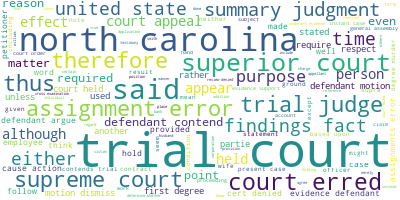

In [0]:
# visual word cloud
total_string = ','.join([','.join(i) for i in clean_texts])
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
wordcloud.generate(total_string)
wordcloud.to_image()

In [0]:
clean_texts

array([list(['rodman', 'writings', 'executed', 'plaintiff', 'defendants', 'respectively', 'formed', 'single', 'contract', 'plaintiff', 'bound', 'convey', 'defendants', 'good', 'title', 'three', 'fourths', 'sawyer', 'land', 'within', 'hundred', 'days', 'defendants', 'bound', 'receiving', 'title', 'plaintiff', 'ordinarily', 'proper', 'consider', 'first', 'right', 'plaintiff', 'recover', 'unaffected', 'supposed', 'defence', 'case', 'convenient', 'first', 'consider', 'dispose', 'defence', 'goes', 'foundation', 'contract', 'could', 'maintained', 'would', 'render', 'consideration', 'case', 'unnecessary', 'defendants', 'allege', 'induced', 'enter', 'contract', 'plaintiff', 'representation', 'owned', 'fourth', 'land', 'could', 'control', 'title', 'additional', 'half', 'representation', 'turned', 'false', 'particulars', 'jury', 'find', 'defendants', 'induced', 'make', 'contract', 'misrepresentation', 'misrepresentation', 'appears', 'complaint', 'plaintiff', 'claimed', 'fourth', 'land', 'contrac

In [0]:
most_common_words = []
fdist = []

for i in range(len(clean_texts)):
    fdist1 = FreqDist(clean_texts[i])
    most_common = fdist1.most_common(20)
    fdist.append(fdist1)
    most_common_words.append(most_common)
filter_s = []

for most_common_words[0] in most_common_words:
    for w in most_common_words[0]: 
        filter_s.append(w) 
        
def Sort_Tuple(tup):
    d = {x:0 for x, _ in tup} 
    for name, num in tup: d[name] += num 
  
    Output = list(map(tuple, d.items())) 
    return(sorted(Output, key = lambda Output: Output[1],reverse = True))
  
sorted_words=Sort_Tuple(filter_s)
sorted_words[:20]

[('defendant', 181040),
 ('court', 137192),
 ('plaintiff', 79730),
 ('evidence', 70679),
 ('trial', 69915),
 ('state', 65653),
 ('case', 38198),
 ('jury', 32900),
 ('upon', 29216),
 ('judgment', 26737),
 ('defendants', 24226),
 ('error', 22171),
 ('plaintiffs', 20337),
 ('property', 19834),
 ('action', 18698),
 ('would', 18688),
 ('order', 16605),
 ('judge', 16255),
 ('motion', 16181),
 ('said', 14095)]

Text(0.5, 1.0, 'Frequency of Top 50 Words in North Carolina Case Law Briefs')

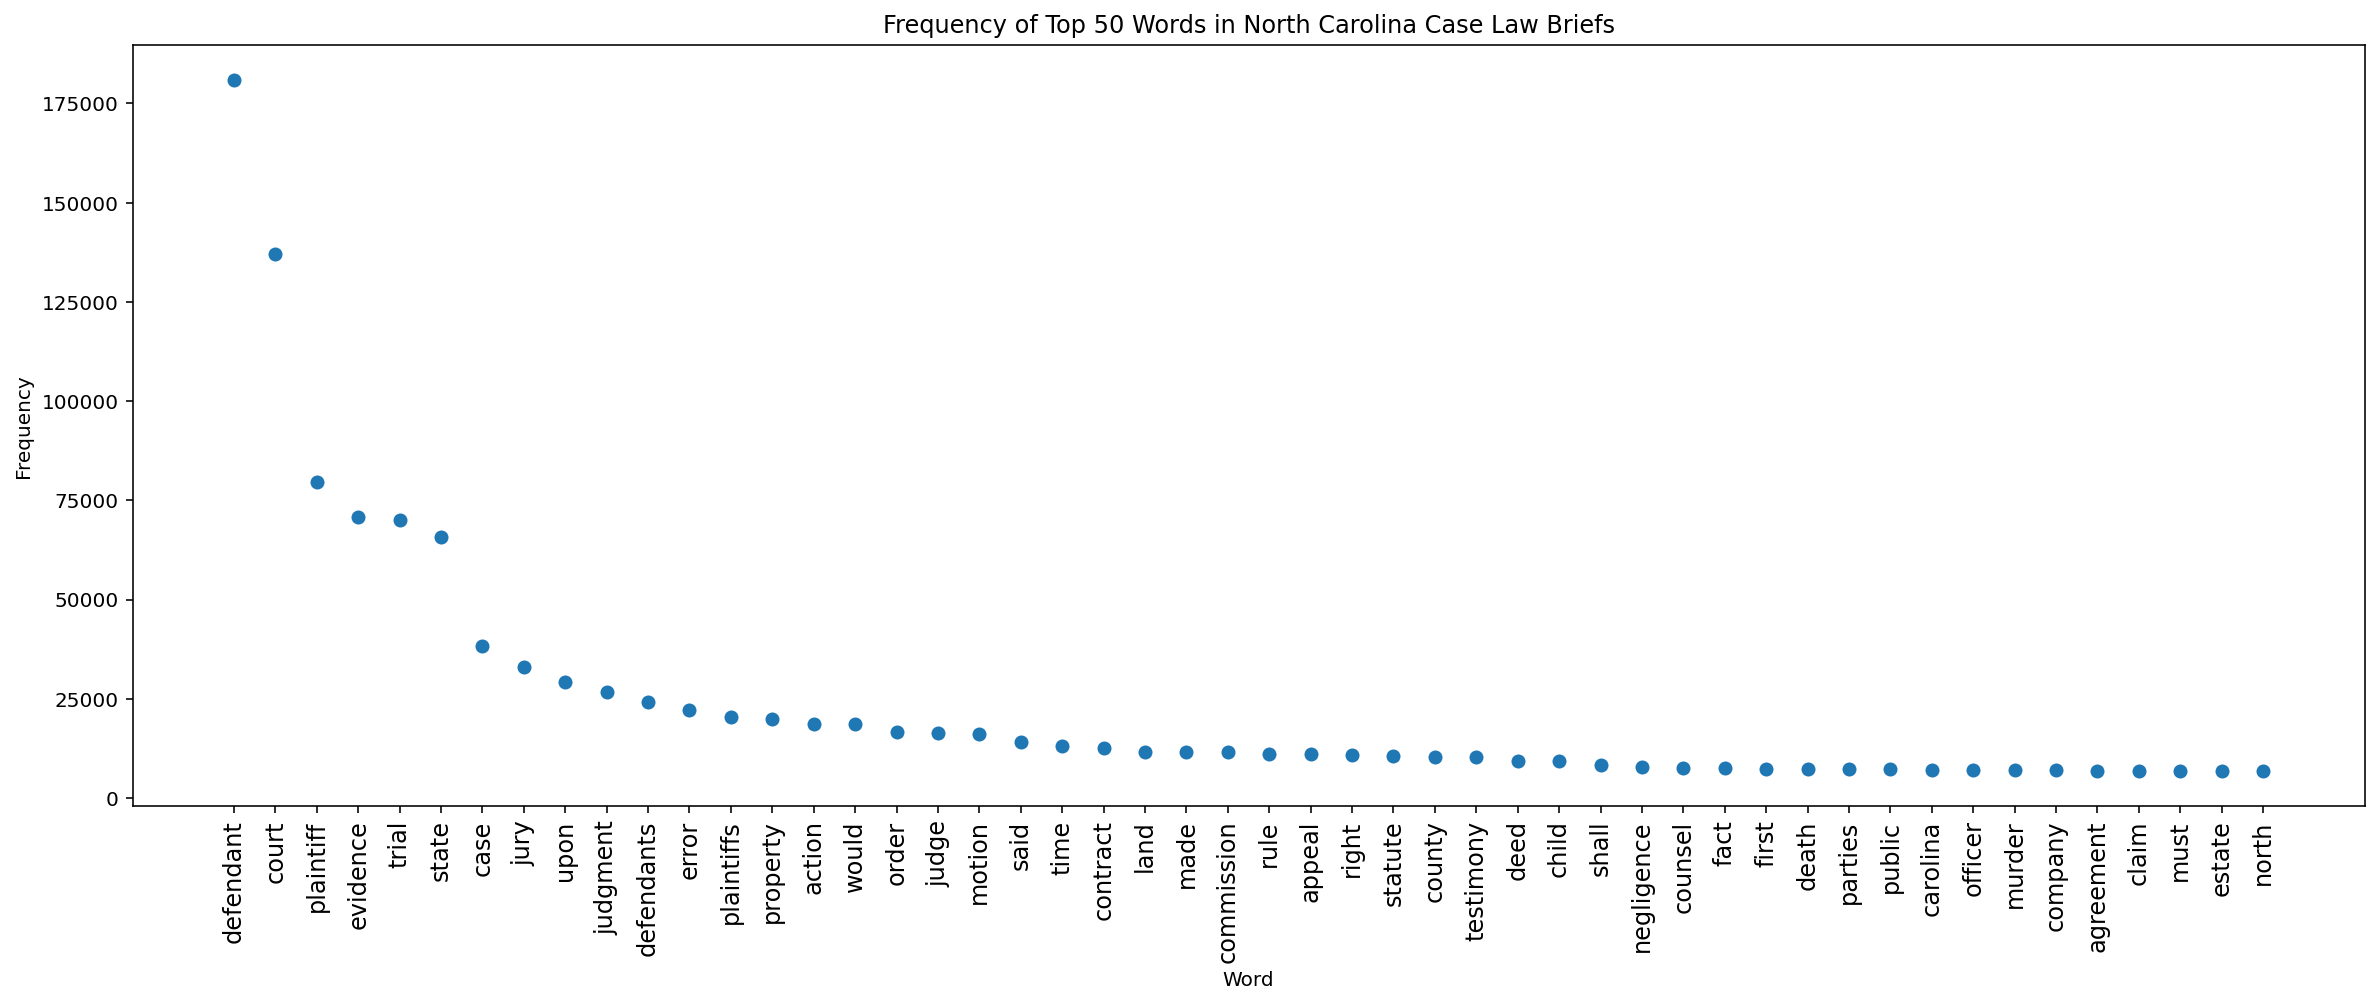

In [0]:
testList2 = [(elem1, elem2) for elem1, elem2 in sorted_words]
plt.figure(figsize=(20,7))
plt.xticks(rotation=90,fontsize=12)
plt.scatter(*zip(*testList2[:50]))
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.title('Frequency of Top 50 Words in North Carolina Case Law Briefs')

# Topic Modelling 
We arbitrarily chose 10 topics to group by at first--ideally, we would try grouping by several different numbers of topics, but due to computational limits, we could only run it once for each state. For this section, we used NLTK's wordnet to find the meaning of words, Gensim to perform LDA, and pyLDAvis to visualize our topics

https://towardsdatascience.com/topic-modelling-in-python-with-nltk-and-gensim-4ef03213cd21

First, we have to clean the data further by lemmatizing--i.e. turning all forms of a word with the same meaning into the root word. 

In [0]:
parser = English()

def tokenize(text):
    lda_tokens = []
    tokens = parser(text)
    for token in tokens:
        if token.orth_.isspace():
            continue
        elif token.like_url:
            lda_tokens.append('URL')
        elif token.orth_.startswith('@'):
            lda_tokens.append('SCREEN_NAME')
        else:
            lda_tokens.append(token.lower_)
    return lda_tokens

In [0]:
def get_lemma(word):
    lemma = wn.morphy(word)
    if lemma is None:
        return word
    else:
        return lemma

In [0]:
en_stop = set(nltk.corpus.stopwords.words('english'))

In [0]:
def prepare_text_for_lda(text):
    tokens = tokenize(text)
    tokens = [token for token in tokens if len(token) > 4]
    tokens = [token for token in tokens if token not in en_stop]
    tokens = [get_lemma(token) for token in tokens]
    return tokens
text_data = []
for case in train['text_majority']:
    tokens = prepare_text_for_lda(case)
    text_data.append(tokens)

dictionary = corpora.Dictionary(text_data)
corpus = [dictionary.doc2bow(text) for text in text_data]

pickle.dump(corpus, open('corpus.pkl', 'wb'))
dictionary.save('dictionary.gensim')

NUM_TOPICS = 10
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)
ldamodel.save('model10.gensim')

Now that we've created our model, we can take a look at how our LDA model decided to group our topics. We print the top five most relevant words for each topic group. 

In [0]:
topics = ldamodel.print_topics(num_words=5)
for topic in topics:
    print(topic)

(0, '0.040*"court" + 0.020*"judgment" + 0.015*"action" + 0.014*"defendant" + 0.011*"appeal"')
(1, '0.049*"plaintiff" + 0.035*"defendant" + 0.018*"court" + 0.013*"trial" + 0.013*"judgment"')
(2, '0.028*"plaintiff" + 0.021*"defendant" + 0.018*"evidence" + 0.015*"negligence" + 0.010*"injury"')
(3, '0.027*"court" + 0.018*"s.e.2d" + 0.014*"appeal" + 0.012*"petitioner" + 0.010*"state"')
(4, '0.054*"defendant" + 0.027*"state" + 0.022*"evidence" + 0.021*"trial" + 0.019*"court"')
(5, '0.044*"court" + 0.031*"child" + 0.024*"order" + 0.021*"trial" + 0.013*"defendant"')
(6, '0.023*"state" + 0.013*"statute" + 0.010*"shall" + 0.010*"public" + 0.010*"property"')
(7, '0.033*"plaintiff" + 0.028*"commission" + 0.016*"employee" + 0.014*"evidence" + 0.013*"injury"')
(8, '0.040*"defendant" + 0.029*"officer" + 0.016*"state" + 0.013*"court" + 0.012*"search"')
(9, '0.015*"plaintiff" + 0.010*"defendant" + 0.009*"property" + 0.008*"estate" + 0.008*"would"')


The topics brought up don't seem particularly distinct, but the most common topic seems to be appeals, which makes sense because the data set was drawn from the Appellate courts in North Carolina. The words in the topics are similar, including words like 'court', 'defendant', 'plaintiff', 'court', 'appeal', and 'evidence'. Despite the lack of clear clustering, there are some topics that contain unique words that leave us to understand that some important topics include negligence, property, workers' compensation, and property. It appears that topic 1 and 2 are general, topic 3 focuses on traffic accidents, 4 on appeals and proceedings, 5 on criminal law, 6 on divorce proceedings and child custody, 7 on disputes between the state and businesses, 8 on medical incidents, 9 on vehicles and traffic infractions (specifically drunk driving), and 10 on estate and property disputes.

In [0]:
dictionary = gensim.corpora.Dictionary.load('dictionary.gensim')
corpus = pickle.load(open('corpus.pkl', 'rb'))
lda = gensim.models.ldamodel.LdaModel.load('model10.gensim')

Finally, we use pyLDAvis to do a more comprehensive visualization and understanding of our topics.

In [0]:
lda_display = pyLDAvis.gensim.prepare(lda, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

## Distribution of Cases Over Time
Lastly, we wanted to look at how the total number of cases has changed over time by looking at the distribution of cases for all of the states.

In [0]:

cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

case_text_df_new['decision_year'] = case_text_df_new['decision_date'].astype(str).str[0:4]
np.sort(case_text_df_new['decision_year'].unique())
case_text_df_new.groupby('decision_year').count()['id'].sort_values(ascending=False).iplot(kind='bar',
                                            yTitle='Count', linecolor='black', opacity=0.8,
                                            title='Bar Chart of Number of Cases per Year', xTitle='Year')
plt.show()

# Baseline Model: TextRank

TextRank is an unsupervised learning and extractive summarization technique that works by calculating the similarity between sentences in a text and ranks them, returning the top ranked sentences as a summary of the text. It does so by using Cosine Similarity, a measure of similarity between two non-zero vectors of an inner product space that measures the cosine of the angle between them. We can use cosine similarity by converting our sentences into numerical vectors. TextRank does not rely on any previous training data and can work with any arbitrary piece of text. TextRank is a general purpose graph-based ranking algorithm for NLP.

###  References:
The following links provided the code that the TextRank model was based upon. Minor changes were made, but these two references were essentially what we modeled our baseline after.

https://www.analyticsvidhya.com/blog/2019/06/comprehensive-guide-text-summarization-using-deep-learning-python/
https://towardsdatascience.com/understand-text-summarization-and-create-your-own-summarizer-in-python-b26a9f09fc70

In [0]:
# choose a random case from the data set
random_case = case_text_df_new['text_majority'][80100]
random_case = random_case.replace('\n','')
random_case_headnote = case_text_df_new['head_matter'][80100]
random_case

'HUDSON, Judge.On 1 July 2002, plaintiff Jones filed a small claims “complaint for money owed” on an Administrative Office of the Courts (AOC) form, alleging that he had sent $2,000 to defendant “in error.” On 3 September 2002, the small claims court, using an AOC form Judgment, agreed “that the plaintiff has proved the case by the greater weight of the evidence,” and ordered defendant Ratley and Best (hereinafter “Ratley”) to pay plaintiff $2,000. Ratley appealed to the district court and on 27 November 2002, the district court arbitrator entered an arbitration award and judgment in favor of Jones. Ratley requested a trial de novo in district court, which was held on 3 March 2003. After the court awarded $2,000 to Jones, Ratley appealed. We affirm.The record includes no transcript, but does contain documentary evidence. From these documents, it appears that in 1997 Ratley sued Jones in Randolph County for $2,000, seeking payment for work Ratley alleged he completed for Jones. Ratley c

In [0]:
random_case_headnote

'DAVID G. JONES, Plaintiff v. EDWARD D. RATLEY and BEST ROOFING COMPANY, DefendantNo. COA03-1496(Filed 18 January 2005)1. Small Claims— de novo appeal to district court — informal processThe district court did not err in a de novo trial from small claims court where defendant apparently contended that the court did not make adequate conclusions and speculated that the court based its decision on a theory of fraud that was not pled with particularity. Defendant does not explain how the claim involved fraud, a complaint in a small claims action need be in no particular form, the legislature intended the informal processes of the small claims court to continue in the de novo appeal, and the district court on a de novo appeal has the discretion to order further pleadings or to try the case as pled.2. Small Claims— appeal to district court — no answerThere was no error in a district court trial de novo from small claims court where the court found that no answer was filed by defendant, as n

In [0]:
generate_summary(case_text_df_new['text_majority'][80100],2) 

Indexes of top ranked_sentence order are  [(0.03441728553178425, ['Thus,', 'the', 'trial', 'court', 'did', 'not', 'abuse', 'its', 'discretion', 'by', 'failing', 'to', 'take', 'judicial', 'notice.Finally,', 'defendant', 'asserts', 'that', 'no', 'theory', 'of', 'law', 'exists', 'which', 'would', 'support', 'an', 'award', 'for', 'plaintiff', 'and', 'that', 'the', 'court', 'erred', 'in', 'not', 'reaching', 'this', 'conclusion.']), (0.03388856462889507, ['Here,', 'defendant', 'does', 'not', 'argue', 'that', 'he', 'requested', 'the', 'court', 'take', 'judicial', 'notice', 'or', 'that', 'he', 'supplied', 'the', 'court', 'with', 'the', 'necessary', 'information.']), (0.03235416829884285, ['Thus,', 'the', 'statute', 'leaves', 'it', 'to', 'the', 'discretion', 'of', 'the', 'court', 'to', 'decide', 'whether', 'the', 'pleadings', 'need', 'detail.Defendant', 'also', 'fails', 'to', 'cite', 'any', 'legal', 'authority', 'supporting', 'his', 'assertion', 'that', 'the', 'trial', 'court', 'must', 'provide

## True Case Text:

HUDSON, Judge.On 1 July 2002, plaintiff Jones filed a small claims “complaint for money owed” on an Administrative Office of the Courts (AOC) form, alleging that he had sent \$2,000 to defendant “in error.” On 3 September 2002, the small claims court, using an AOC form Judgment, agreed “that the plaintiff has proved the case by the greater weight of the evidence,” and ordered defendant Ratley and Best (hereinafter “Ratley”) to pay plaintiff \$2,000. Ratley appealed to the district court and on 27 November 2002, the district court arbitrator entered an arbitration award and judgment in favor of Jones. Ratley requested a trial de novo in district court, which was held on 3 March 2003. After the court awarded \$2,000 to Jones, Ratley appealed. We affirm.The record includes no transcript, but does contain documentary evidence. From these documents, it appears that in 1997 Ratley sued Jones in Randolph County for \$2,000, seeking payment for work Ratley alleged he completed for Jones. Ratley contends in his brief that Jones’s mortgage company contacted him at the time and requested that he drop the suit so that Jones’s closing could proceed. In return, Ratley would be paid \$2,000 out of the closing. Ratley introduced a letter he wrote to the mortgage company on 5 July 2000 indicating he would drop his suit upon receipt of the \$2,000. However, the record indicates that the case was dismissed on 13 June 2000 by entry of an order entitled “Order of Dismissal (Pursuant to Rule 41 (b)).” N.C. Gen. Stat. § 1A-1, Rule 41(b) (2003) (involuntary dismissal “for failure of the plaintiff to prosecute”). The date of the order preceded by several weeks the letter to the mortgage company, when “the plaintiff [“Ratley”] informed the court that he did not wish to proceed.” The current case arose when Jones sued Ratley in 2002, claiming that he sent \$2,000 to Ratley in error.Defendant contends here that the court erred by “making no findings as to what theory of law” supported its judgment. In his brief, defendant appears to be arguing actually that the court did not make adequate conclusions of law, as it did not specify its legal theory, but he cites no authority for this proposition. Defendant then speculates that the trial court based its decision on a theory of fraud and argues that fraud was not pled with particularity by plaintiff here. Although defendant cites cases supporting the argument that fraud must be pled with particularity, he does not explain how this claim involved fraud. To the contrary, defendant acknowledges thát “[p]laintiff speaks of an error, but never really says that he was defrauded.” Thus we decline to hold that those cases apply. In addition, the complaint in a small claim action “need be in no particular form, but is sufficient if in a form which enables persons of common understanding to know what is meant.” N.C. Gen. Stat. § 7A-216 (2003). Furthermore, in a trial de novo on appeal to the district court, the judge “may order repleading or further pleading ... or may try [the case] on the pleadings as filed.” G.S. § 7A-229 (2003) (emphasis added). Thus, the statute leaves it to the discretion of the court to decide whether the pleadings need detail.Defendant also fails to cite any legal authority supporting his assertion that the trial court must provide more detailed legal con- elusions in an appeal to the district court from small claims court. While Rule 52 of the North Carolina Rules of Civil Procedure requires that the trial courts in general state conclusions of law separately, we believe the General Assembly has indicated that these types of formalities do not apply in small claims proceedings, including the de novó appeal in district court. The “simple forms and procedures” of small claims court were devised by the legislature to provide citizens with “an expedient, inexpensive, speedy forum in which they can process litigation involving small sums without obtaining a lawyer.” Duke Power Co. v. Daniels, 86 N.C. App. 469, 472, 358 S.E.2d 87, 89 (1987). In order to facilitate simplified litigation, many of the rules of civil procedure do not apply to small claims court. See, e.g., G.S. § 7A-216 (2003) (no particular form of complaint required); G.S. § 7A-220 (2003) (no required pleadings other than complaint); G.S. § 7A-222 (2003) (rules of evidence “generally are observed”). Thus, in the absence of any statute or other authority suggesting that legal theories be formally described in these cases, we decline to create such a requirement.Further, reading the statutory provisions governing appeals from small claims, G.S. §§ 7A-225, et seq., in pari materia, we conclude that unless otherwise specified, the legislature intended that the informal processes of the small claims court continue in the de novo appeal. In this regard, G.S. § 7A-229 provides: “The district judge before whom the action is tried may order repleading or further pleading by some or all of the parties; may try the action on stipulation as to the issue; or may try it on the pleadings as filed.” Here, the district court did not require further pleadings and did make findings of fact and conclusions of law, indicating that “plaintiff over paid defendant in an amount not less than \$2,000” and that plaintiff was entitled to recover that sum plus interest. The documents support the findings, which in turn support the conclusions and the judgment. We conclude that the court acted within the statutory process and properly exercised its discretion, and we decline to disturb the judgment on this basis.Defendant also argues that the court erred in finding that no answer or other responsive pleading was filed by defendant, as no answer is required in a proceeding appealed from the magistrate’s court. As noted above, in a small claims action, no pleadings beyond a complaint are required and no response is considered a general denial. G.S. § 7A-220 (2003). Defendant does not argue that the finding was erroneous, nor does he explain how the court’s finding harmed him or influenced the case. We overrule this assignment of error.Defendant also asserts that the court erred by finding that plaintiffs closing attorney gave defendant \$2,000 under the belief that there was a valid judgment on the record. Defendant contends that there was no basis to support this finding. “A judge is subject to reversal for abuse of discretion only upon a showing by a litigant that the challenged actions are manifestly unsupported by reason.” Clark v. Clark, 301 N.C. 123, 129, 271 S.E.2d 58, 63 (1980). Here, we conclude that evidence did support the court’s finding and conclusion, specifically the letter from defendant to the plaintiffs mortgage company promising to “dismiss” the suit in return for \$2,000 when it had already been dismissed. Defendant’s argument has no merit.Defendant further argues that the court erred by not taking judicial notice of the fact that judgments are public records and plaintiff’s closing attorney thus had constructive notice of the status of any judgment. We disagree. Rule 201 of the North Carolina Rules of Evidence clearly states that judicial notice is discretionary: “A court may take judicial notice, whether requested or not.” G.S. § 8C-1, Rule 201 (c) (2003) (emphasis added). Judicial notice is mandatory only where “requested by a party and supplied with the necessary information.” G.S. § 8C-1, Rule 201 (d). Here, defendant does not argue that he requested the court take judicial notice or that he supplied the court with the necessary information. Thus, the trial court did not abuse its discretion by failing to take judicial notice.Finally, defendant asserts that no theory of law exists which would support an award for plaintiff and that the court erred in not reaching this conclusion. We have discussed the essence of this argument above, under defendant’s first assignment of error, and for the same reasons, we find it lacks merit.Affirmed.Judge BRYANT concurs.Judge TYSON dissents.
## TextRank Generation
 Here, defendant does not argue that he requested the court take judicial notice or that he supplied the court with the necessary information.. Defendant also fails to cite any legal authority supporting his assertion that the trial court must provide more detailed legal con- elusions in an appeal to the district court from small claims court.
## 3rd Party Headnote 
DAVID G. JONES, Plaintiff v. EDWARD D. RATLEY and BEST ROOFING COMPANY, DefendantNo. COA03-1496(Filed 18 January 2005)1. Small Claims— de novo appeal to district court — informal processThe district court did not err in a de novo trial from small claims court where defendant apparently contended that the court did not make adequate conclusions and speculated that the court based its decision on a theory of fraud that was not pled with particularity. Defendant does not explain how the claim involved fraud, a complaint in a small claims action need be in no particular form, the legislature intended the informal processes of the small claims court to continue in the de novo appeal, and the district court on a de novo appeal has the discretion to order further pleadings or to try the case as pled.2. Small Claims— appeal to district court — no answerThere was no error in a district court trial de novo from small claims court where the court found that no answer was filed by defendant, as no answer is required in small claims (no response is a general denial). Defendant does not argue that the finding is erroneous or explain how he was harmed.3. Courts— district — finding—supported by evidenceThe evidence supported the district court’s finding and conclusion regarding disputed funds paid from a closing under the belief that there was a valid judgment on the record.4. Trials— judicial notice — not requested — necessary information not suppliedThe trial court did not abuse its discretion by not taking judicial notice that judgments are public records that could have been checked by a closing attorney where defendant did not argue that he requested that the court take judicial notice or that he supplied the court with the necessary information.Judge Tyson dissenting.Defendant appeals from judgment entered 8 August 2003 by Judge Thomas G. Foster, Jr. in Guilford County District Court. Heard in the Court of Appeals 1 September 2004.Douglas S. Harris, for defendant-appellant.No brief filed for plaintiff-appellee.


## Issues with this baseline model:

This summary is not ideal. While it provides us with an idea of what the most important sentences in the text may be, with the thought that those sentences may have a decent amount of information in them about the case, this model doesn't provide a true summarization. The model is unable to generate new text, which substantially limits its ability to summarize the entirety of the case's facts and findings. In addition, ideally we would want to immediately know what the decision of the court was for the case (for example, Affirmed). Since this model is unsupervised, we also have no way to assess how good our chosen sentences are for summarizing the text. A better model would be able to identify the key facts and findings of the case and be a supervised model to assess how well our summaries are doing versus the 3rd party generated headnotes. 


# Training a Custom Sequence-To-Sequence Model with Attention on Case Data

Using certain headnotes that are much shorter than the majority text, we can build a Seq2Seq model where the in input is the majority opinion text and the output is the headnote (a summary). We can model this as a Many-to-Many Seq2Seq problem.  

This Seq2Seq models is composed of an Encoder-Decoder, which is mainly used to solve Seq2Seq prolems where the input and output sequences are of different lengths.  The components of this network are stacked LSTMs, as LSTMSs are capable of capturing long term dependencies while avoiding the vanishing gradient problem of an RNN, and stacked LSTM's can lead to better representation of sequences.

The Encoder-Decoder is set up in two phases, the training phase and the inference phase.

In the training phase, the model is trained to predict the target sequence offset by one timestep. 

After training, the model is tested on new source sequences for which the target sequence is unknown. 

To overcome limitations of the encoder for longer sequences,  an attention mechanism is added to the model to predict a word by looking at a few specific parts of the sequence only, rather than the entire sequence, increasing the importance of specific parts of the sequence that result in the target sequence.



### Preprocessing  Data

In [0]:
## Model: https://www.analyticsvidhya.com/blog/2019/06/comprehensive-guide-text-summarization-using-deep-learning-python/


# change directory so custom import can be accessed
# RUN ONCE
# only need to run once
# lets you use the data in Google Drive folder I shared before (CS109b Final Project)
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir("drive/My Drive/CS109b Final Project")
# file added to directory
from attention import AttentionLayer

## import other libraries
import numpy as np  
import pandas as pd 
import re           
from bs4 import BeautifulSoup 
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords   
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Using TensorFlow backend.


In [0]:
# preprocessing from article, do not think contraction mapping necessary
# as law code is formal
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",

                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

                           "you're": "you are", "you've": "you have"}


In [0]:
stop_words = set(stopwords.words('english')) 
def text_cleaner(text):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    tokens = [w for w in newString.split() if not w in stop_words]
    long_words=[]
    for i in tokens:
        if len(i)>=3:                  #removing short word
            long_words.append(i)   
    return (" ".join(long_words)).strip()

def summary_cleaner(text):
    newString = re.sub('"','', text)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString)
    newString = newString.lower()
    tokens=newString.split()
    newString=''
    for i in tokens:
        if len(i)>1:                                 
            newString=newString+i+' '  
    return newString
# clean
case_text_df_new["text_majority_clean"] = case_text_df_new["text_majority"].apply(text_cleaner)
case_text_df_new["head_matter_clean"] = case_text_df_new["head_matter"].apply(summary_cleaner)

In [0]:
case_text_df_new["head_matter_clean"].replace('', np.nan, inplace=True)
# Drop na's
case_text_df_new = case_text_df_new.dropna(subset=["text_majority_clean","head_matter_clean"], how='any')

#dropna(axis=0,inplace=True)


case_text_df_new['head_matter_clean'] = case_text_df_new['head_matter_clean'].apply(lambda x : '_START_ '+ x + ' _END_')

In [0]:

for i in range(5):
    print("Majority:",case_text_df_new['text_majority_clean'][i])
    print("Headnote:",case_text_df_new['head_matter_clean'][i])
    print("\n")

Majority: majority court therefore latter opinion bill indictment pronounced exceptionable consequently upon sentence death cannot passed upon prisoner keeper jail received mittimus retain prisoner course remain jail october term superior court new bill drawn another trial take place
Headnote: _START_ supreme court raleigh july the state vs john owen murder in an indictment for murder the length and depth of the wound must be expressed hawk chitty this case came oil to be argued before the supreme court on exceptions taken to the indictment in behalf of the prisoner the exceptions were that the mortal wounds alleged to have occasioned the death were pot positively alleged to have been given by the prisoner but were only to be collected by intendment or implication and that the length and depth of the wounds alleged were not described to be of any dimensions as to the first exception the judges were unanimous that the wounds were laid to have been given by the prisoner with sufficient c

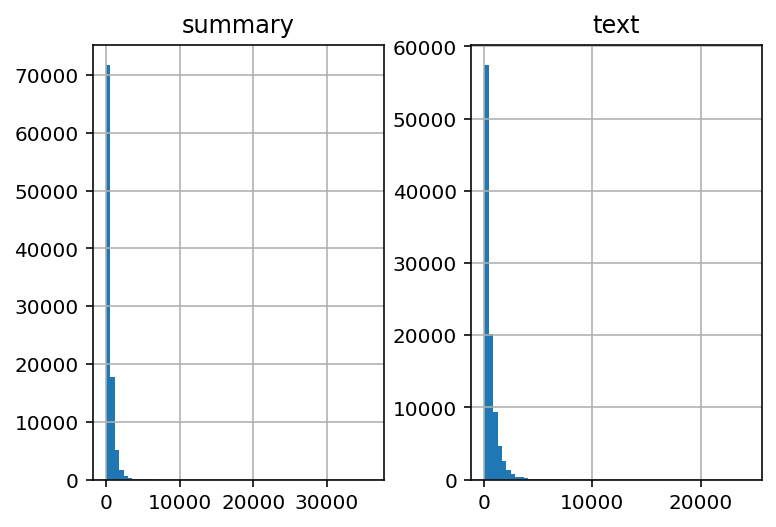

In [0]:
#Here, we will analyze the length of the reviews and the summary 
# to get an overall idea about the distribution of length 
# of the text. This will help us fix the maximum length of the
# sequence:
import matplotlib.pyplot as plt
text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in case_text_df_new['text_majority_clean']:
      text_word_count.append(len(i.split()))

for i in case_text_df_new['head_matter_clean']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})
length_df.hist(bins = 60)
plt.show()

In [0]:
# filter out cases where head matter > 20% and <1% text majority for training labelled data
deep_df = case_text_df_new.loc[(case_text_df_new["head_matter_clean"].str.len()/case_text_df_new["text_majority"].str.len()) <= 0.2, :]
deep_df = deep_df.loc[(deep_df["head_matter"].str.len()/deep_df["text_majority"].str.len()) >= 0.01, :]
len(deep_df)

18454

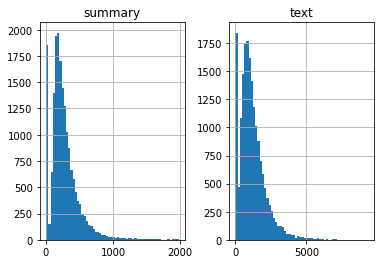

In [0]:
#Here, we will analyze the length of the reviews and the summary 
# to get an overall idea about the distribution of length 
# of the text. This will help us fix the maximum length of the
# sequence:
import matplotlib.pyplot as plt
text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in deep_df['text_majority_clean']:
      text_word_count.append(len(i.split()))

for i in deep_df['head_matter_clean']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})
length_df.hist(bins = 60)
plt.show()

In [0]:
from sklearn.model_selection import train_test_split

# START FROM HERE TO READ IN PREPROCESSED DATA
# set max lengths to 1,000, 5,000
max_summary = 1000
max_majority = 5000

#deep_df.to_csv("deep_learning_design.csv")
deep_df = pd.read_csv("deep_learning_design.csv")

deep_df = deep_df.iloc[((pd.Series(text_word_count) < max_majority) & (
    pd.Series(summary_word_count) < max_summary)).values, :]

# train test split
x_tr,x_val,y_tr,y_val=train_test_split(deep_df['text_majority_clean'][:360],deep_df['head_matter_clean'][:360],test_size=0.1,random_state=0,shuffle=True) 
len(deep_df)

18074

In [0]:
#prepare a tokenizer for majority opinions on training data
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr,  maxlen=max_majority, padding='post') 
x_val   =   pad_sequences(x_val, maxlen=max_majority, padding='post')

x_voc_size   =  len(x_tokenizer.word_index) +1

In [0]:
#preparing a tokenizer for head_note on training data 
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_tr))

#convert summary sequences into integer sequences
y_tr    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr, maxlen=max_summary, padding='post')
y_val   =   pad_sequences(y_val, maxlen=max_summary, padding='post')

y_voc_size  =   len(y_tokenizer.word_index) +1

## Seq2Seq w/ Attention Modeling

In [0]:
# Model building
from keras import backend as K 
K.clear_session() 
latent_dim = 33#500 


# Encoder 
encoder_inputs = Input(shape=(max_majority,)) 
enc_emb = Embedding(x_voc_size, latent_dim,trainable=True)(encoder_inputs) 

#LSTM 1 
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb) 

#LSTM 2 
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1) 

#LSTM 3 
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True) 
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)#1

# Set up the decoder. 
decoder_inputs = Input(shape=(None,)) 
dec_emb_layer = Embedding(y_voc_size, latent_dim,trainable=True) 
dec_emb = dec_emb_layer(decoder_inputs) 

#LSTM using encoder_states as initial state
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True) 
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c]) 

#Attention Layer EDITED
##Attention layer 
attn_layer = AttentionLayer(name='attention_layer') 
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs]) 

# Concat attention output and decoder LSTM output 
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])


#Dense layer
decoder_dense = TimeDistributed(Dense(y_voc_size, activation='softmax')) 
decoder_outputs = decoder_dense(decoder_concat_input) 

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs) 
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 5000)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 5000, 33)     531366      input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 5000, 33), ( 8844        embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [0]:
# DETERMINE RAM PER MODEL, batch_size

def get_model_memory_usage(batch_size, model):
    import numpy as np
    from keras import backend as K

    shapes_mem_count = 0
    internal_model_mem_count = 0
    for l in model.layers:
        #print(l)
        layer_type = l.__class__.__name__
        if layer_type == 'Model':
            internal_model_mem_count += get_model_memory_usage(batch_size, l)
        single_layer_mem = 1
        
        # fix list of size 1 error
        #print(l.output_shape)
        if (type(l.output_shape) != list) & (type(l.output_shape[0]) != tuple):
            output_shape = [l.output_shape]
        else:
            output_shape = l.output_shape
        #print(output_shape)

        #skip over nonetype
        for val in output_shape:
          for s in val:
              
              if s is None:
                  continue
              
              single_layer_mem *= s
        shapes_mem_count += single_layer_mem

    from keras.utils.layer_utils import count_params

    trainable_count = count_params(model.trainable_weights)
    non_trainable_count = count_params(model.non_trainable_weights)
    
    number_size = 4.0
    if K.floatx() == 'float16':
         number_size = 2.0
    if K.floatx() == 'float64':
         number_size = 8.0
  
    total_memory = number_size*(batch_size*shapes_mem_count + trainable_count + non_trainable_count)
    gbytes = np.round(total_memory / (1024.0 ** 3), 3) + internal_model_mem_count
    return gbytes

print("Estimated RAM: {}".format(get_model_memory_usage(10, model)))

Estimated RAM: 20.1


In [0]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
#history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=10,callbacks=[es],batch_size=5, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))


In [0]:
#history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=10,callbacks=[es],batch_size=5, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

#model.save_weights("deep_learning_weights.h5")
model.load_weights("deep_learning_weights.h5")

In [0]:
reverse_target_word_index=y_tokenizer.index_word 
reverse_source_word_index=x_tokenizer.index_word 
target_word_index=y_tokenizer.word_index

# encoder inference
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# decoder inference
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_majority,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat)

# Final decoder model
decoder_model = Model(
[decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
[decoder_outputs2] + [state_h2, state_c2])

In [0]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Chose the 'start' word as the first word of the target sequence
    target_seq[0, 0] = target_word_index['start']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if(sampled_token!='end'):
            decoded_sentence += ' '+sampled_token

            # Exit condition: either hit max length or find stop word.
            if (sampled_token == 'end' or len(decoded_sentence.split()) >= (max_summary-1)):
                stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [0]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
      if((i!=0 and i!=target_word_index['start']) and i!=target_word_index['end']):
        newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
      if(i!=0):
        newString=newString+reverse_source_word_index[i]+' '
    return newString



---



In [0]:
for i in range(len(x_val[:10])):
  print("Majority Opinion:",seq2text(x_val[i]))
  print("Original summary:",seq2summary(y_val[i]))
  print("Predicted summary:",decode_sequence(x_val[i].reshape(1,max_majority)))
  print("\n")

Majority Opinion: tbe defendants indicted tbe court tbe crime willfully killing dog tbe property tbe prosecutor would vain discuss tbe purpose deciding tbat dog living creature witbin tbe meaning eevisal sec tbe indictment drawn presented tbe grand jury bave beld tbat subject property animal merely tbat civil action may maintained damages caused injury bim though may guilty youthful indiscretion harmless transgression dog like man one respect least tbat wrong sometimes wrong slight trivial thereby forfeit bis life tbe opinion judge gaston dodson mock generally taken clear accurate statement tbe law regard tbe right property much sometimes useful animal tbat civil action recover damages killing tbe plaintiff dog tbe defendant contending tbat dog property therefore action would lie injury bim view contention judge gaston said necessary tbe maintenance tbe action tbat tbe plaintiff dog shown bave pecuniary value dogs belong tbat class domiciled animals tbe law recognizes objects property 

# Abstractive Text Summarization with BERT Transformer

Transformers are model that boost performance speed using self-attention.  Bidirectional Encoder Representations from Transformers, BERT, are a recent incarnation of pretrained language models which has high-performing capabilities for a multitude of NLP tasks.  One of these tasks BERT can be used for is summarization, both extractive and abstractive.  The model we have obtained is a pretrained abtractive BERT summarization model (Liu and Lapata).

BERT is trained with a masked language modeling (output vectors are grounded in tokens instead of sentences) and a "next sentence prediction" task on a corpus of 3,300M words.  The general architecture is as follows: 

Input text is first preprocessed by inserting two special tokens - one predating the whole text, one before each sentence.  The modified text is then represented as a sequence of tokens, with each token assigned three kinds of embeddings corresponding to the meaning of the token, the discrimination between two tokens, and the position of the token within the text sequence, respectively.  These three embeddings sum to a single input vector and are fed to a bidirectional Transformer with multiple layers.  On the top layer of the transformer, BERT generates an output vector for each token full of contextual information (Liu and Lapata).

BERTSUM extends BERT by inserting multiple symbols to learn sentence representations and using interval
segmentation embeddings to distinguish multiple sentences (Liu and Lapata). 

For abstractive summarization, the standard encoder-decoder framework is used, with the encoder being a pretrained BERTSUM and the decoder being a 6-layered Transformer initialized randomly (Liu and Lapata).



References:

Yang Liu and Mirella Lapata. 2019. Text summarization with pretrained encoders. In Proceedings of
the 2019 Conference on Empirical Methods in Natural Language Processing and the 9th International
Joint Conference on Natural Language Processing
(EMNLP-IJCNLP), pages 3728–3738, Hong Kong,
China. Association for Computational Linguistics.



In [0]:
# NOTE: the training data for this model was CNN and Daily Mail Articles


# References:

# Research paper BERTsum comes from: https://arxiv.org/pdf/1908.08345.pdf
# github open source: https://github.com/huggingface/transformers/tree/master/examples/summarization/bertabs

# https://towardsdatascience.com/summarization-has-gotten-commoditized-thanks-to-bert-9bb73f2d6922
# text summarization using BERT transformer


# CODE YOU SHOULDNT HAVE TO RUN######################################

# Pull and install Huggingface Transformers Repo
# Clone into shared folder. I believe I ran this for you
#!git clone https://github.com/huggingface/transformers drive/My\ Drive/CS109b\ Final\ Project/transformers

# Create Directory for saving texts
#!mkdir drive/My\ Drive/CS109b\ Final\ Project/transformers/examples/summarization/bertabs/cases

# Create Directory for saving summaries
#!mkdir drive/My\ Drive/CS109b\ Final\ Project/transformers/examples/summarization/bertabs/case_summaries

# Overwriting files in the transformer to debug errors
# when running this locally, taking the . out of .utlils_summarization import seemed to fix it
#!cp -f drive/My\ Drive/CS109b\ Final\ Project/run_summarization.py drive/My\ Drive/CS109b\ Final\ Project/transformers/examples/summarization/bertabs/run_summarization.py
############################################################3


# CODE TO RUN ONLY ONCE
# Run this code to install dependencies
#!cd drive/My\ Drive/CS109b\ Final\ Project/transformers && pip install . && pip install nltk py-rouge
#!pip install transformers
###################################################################


# # Select a subset of articles to summarize
#subset = case_text_df_new.head(10)
subset = case_text_df_new[80099:80101] # halie
# subset = case_text_df_new[80099:81099] # emily
#  Save to Directory to run
# for now, each case is a separate txt file
for index, case in subset.iterrows():
  # file_name -> could name with metadata for text
  file_name = "case{0}.txt".format(case["id"])
  text_file = open("drive/My Drive/CS109b Final Project/transformers/examples/summarization/bertabs/cases/{0}".format(file_name), "w")
  text_file.write(case["text_majority"])
  text_file.close()

# Store Parameters as Variables
DOC_DIR = "cases"
SUMMARIES_DIR = "case_summaries" # defaults to current directory
batch_sz = 1                      #64 Batch size per GPU/CPU for training
min_len = 10                      #50 Minimum number of tokens for the summaries
max_len = 200                     #200 Maximum number of tokens for the summaries
bm_sz = 5                         #number of beams to start with for each example
blk_tri = True                    #true Whether to block the existence of repeating trigrams 
                                      #in the text generated by beam search
alph = 0.95                       #0.95 the value of alpha for the length penalty
                                      # in the beam search (larger value provides larger penalty)


## This line of code is run in terminal in next cell with given params below
# ! python run_summarization.py \
#     --documents_dir DOC_DIR \
#     --summaries_output_dir SUMMARIES_DIR \
#     --batch_size batch_sz \ 
#     --min_length min_len \
#     --max_length max_len \
#     --beam_size bm_sz \
#     --alpha alph \
#     --block_trigram blk_tri \
# to show if files are there
#!ls transformers/examples/summarization/bertabs
#!ls drive/My\ Drive/CS109b\ Final\ Project/

In [0]:
# Run the transformer, change the parameter values above instead of here:
! cd drive/My\ Drive/CS109b\ Final\ Project/transformers/examples/summarization/bertabs && python run_summarization.py --documents_dir "$DOC_DIR" --summaries_output_dir "$SUMMARIES_DIR" --batch_size "$batch_sz" --min_length "$min_len" --max_length "$max_len" --beam_size "$bm_sz" --alpha "$alph" --block_trigram "$blk_tri"

Traceback (most recent call last):
  File "run_summarization.py", line 12, in <module>
    from modeling_bertabs import BertAbs, build_predictor
  File "/content/drive/My Drive/CS109b Final Project/transformers/examples/summarization/bertabs/modeling_bertabs.py", line 30, in <module>
    from configuration_bertabs import BertAbsConfig
  File "/content/drive/My Drive/CS109b Final Project/transformers/examples/summarization/bertabs/configuration_bertabs.py", line 19, in <module>
    from transformers import PretrainedConfig
ModuleNotFoundError: No module named 'transformers'


In [0]:
#subset[0]
#! printf '"$DOC_DIR"'

# print the texts and their summaries
for id in subset["id"].values:
  # file_name -> could name with metadata for text
  file_name = "case{0}_summary.txt".format(id)
  text_file = open("drive/My Drive/CS109b Final Project/transformers/examples/summarization/bertabs/{0}/{1}".format(SUMMARIES_DIR, file_name), "r")
  print("Case id: {}".format(id))
  print("\nText: ")
  print(subset.loc[subset["id"] == id, "text_majority"])
  print("\nSummary: ")
  print(text_file.read())
  print("\n\n\n")
  text_file.close()

Case id: 8468159

Text: 
80099    HUNTER, Judge.Plaintiffs, Kay Frances Fox Taylor and the Estate of Thomas Graham, present the following issues for our consideration: Whether the trial court erroneously denied their motion for ju...
Name: text_majority, dtype: object

Summary: 
kay frances fox taylor and the estate of thomas graham , presented their verdicts. based on the evidence , we conclude the trial court mistakenly denied their motion for judgment. lucille morrison made her son 's attomey in august 2000. the power of attorney did not contain the express authority to make gifts




Case id: 8468420

Text: 
80100    HUDSON, Judge.On 1 July 2002, plaintiff Jones filed a small claims “complaint for money owed” on an Administrative Office of the Courts (AOC) form, alleging that he had sent $2,000 to defendant “i...
Name: text_majority, dtype: object

Summary: 
the small claims court , using an aoc form judgment , agreed $ 2,000 in favor of defendant jones. the district court arbitrat

In [0]:
# print output
#text_file = open("transformers/examples/summarization/bertabs/cases/test_case_summary.txt", "r")
#text_file.read()

!ls drive/My\ Drive/CS109b\ Final\ Project/transformers/examples/summarization/bertabs/cases

case11272108.txt  case11273468.txt  case11274050.txt  case1268383.txt  case.txt
case11272573.txt  case11273534.txt  case11645357.txt  case8468159.txt
case11272694.txt  case11274033.txt  case11956941.txt  case8468420.txt


In [0]:
case_text_df_new['head_matter'][80100]

'DAVID G. JONES, Plaintiff v. EDWARD D. RATLEY and BEST ROOFING COMPANY, DefendantNo. COA03-1496(Filed 18 January 2005)1. Small Claims— de novo appeal to district court — informal processThe district court did not err in a de novo trial from small claims court where defendant apparently contended that the court did not make adequate conclusions and speculated that the court based its decision on a theory of fraud that was not pled with particularity. Defendant does not explain how the claim involved fraud, a complaint in a small claims action need be in no particular form, the legislature intended the informal processes of the small claims court to continue in the de novo appeal, and the district court on a de novo appeal has the discretion to order further pleadings or to try the case as pled.2. Small Claims— appeal to district court — no answerThere was no error in a district court trial de novo from small claims court where the court found that no answer was filed by defendant, as n

### Rouge Scores:

ROUGE stands for Recall-Oriented Understudy for Gisting Evaluation. It is essentially of a set of metrics for evaluating automatic summarization of texts as well as machine translation. It works by comparing an automatically produced summary or translation against a set of reference summaries (typically human-produced).

https://rxnlp.com/how-rouge-works-for-evaluation-of-summarization-tasks/#.Xrh0oGhKg2w

Rouge: Usage: Can feed by file, by line, or lists of lines and can calculate mean:

https://pypi.org/project/rouge/


In [0]:
subset.loc[80099]["head_matter"]

'ESTATE OF THOMAS GRAHAM and KAY FRANCES FOX TAYLOR, Plaintiffs v. LUCILLE MORRISON, JOHN HALLMAN, and LADD MORRISON, DefendantsNo. COA03-1673(Filed 18 January 2005)1. Powers of Attorney— conveyance by attorney-in-fact to herself — alleged services as consideration — value compared to value of propertyPlaintiffs’ motion for a judgment notwithstanding the verdict should have been granted in an action challenging an attorney-in-fact’s conveyance of the principal’s property to herself. There was no testimony indicating that the value of the services provided by the attorney-in-fact were comparable to the value of the land, and there was testimony indicating that the land was not conveyed to the attorney-in-fact as compensation for her services.2. Powers of Attorney— conveyance of principal’s property— no power of gift — transfer not payment for servicesThe trial court erroneously denied plaintiffs’ motion for a judgment notwithstanding the verdict in an action challenging an attorney-in-f

In [0]:
#pip install rouge

from rouge import FilesRouge
from rouge import Rouge


files_rouge = FilesRouge()
rouge_o = Rouge()

#scores = files_rouge.get_scores(hyp_path, ref_path)
# or

!ls drive/My\ Drive/CS109b\ Final\ Project/transformers/examples/summarization/bertabs/cases

import os
import re

for root, dirs, files in os.walk("drive/My Drive/CS109b Final Project/transformers/examples/summarization/bertabs/cases"):
    # print the texts and their rouge scores
    # iterate through texts
    for filename in files:
        print(filename)
        #### ABOVE IS A WAY TO ITERATE THROUGH CASES IF THEY HAVE ALREADY BEEN SAVED AS FILE: THIS CAN CHANGE!!
      
        # get case file id
        id = re.match("case(.*).txt", filename).group(1)

        # open files
        sum_filename = "case{0}_summary.txt".format(id)

        text_file_path = "drive/My Drive/CS109b Final Project/transformers/examples/summarization/bertabs/{0}/{1}".format("cases", filename)
        sum_file_path = "drive/My Drive/CS109b Final Project/transformers/examples/summarization/bertabs/{0}/{1}".format("case_summaries", sum_filename)
        text_file = open(text_file_path, "r")
        sum_file = open(sum_file_path, "r")
        
        # Get headnote
        # if the case_num is in the subset we created
        if (id != ""):
          if (int(id) in subset.id.values):

            # Get Head note
            head_note = subset.loc[subset["id"] == int(id), "head_matter"].values[0]
            print("\nHeadnote: {}".format(head_note))
            print("\nSummary: {}".format(sum_text))

            # print head note summary rouge scores
            # get rouge score
            # have head_note be reference summary
            scores = rouge_o.get_scores(sum_text, head_note)[0]
      
            print("\nRouge Scores SUMMARY VS HEADNOTE:")
            print("\tRouge 1: Overlap of unigrams- f1-score, precision, recall: {}".format(scores["rouge-1"]))
            print("\tRouge 2:  Overlap of bigrams- f1-score, precision, recall: {}".format(scores["rouge-2"]))
            print("\tRouge L:  Longest Common Subsequence based statistics- f1-score, precision, recall: {}".format(scores["rouge-l"]))
            print("\n\n\n")

        # PRINTING: COMMENTED OUT
        # Get texts to compare for rouge scores
        # text = text_file.read()
        # sum_text = sum_file.read()
        # print("Case id: {}".format(id))
        # print("\nText: ")
        # print(text)
        # print("\nSummary: ")
        # print(sum_text)

        # make text file content one line for line by line comparison
        content_one_line = " ".join(text.splitlines())#  " ".join(map(lambda s: s.rstrip('\n'), text_file.read()))

        #print("\nContent one line: {}".format(content_one_line))

        # @@@@@@ EMILY HALIE HERE IS ALL OF THE ROUGE COMPARISON CODE, CAN DO MORE THAN JUST ONE AT A TIME AS WELL AND HAVE AVERAGES CALCULATED: SEE LINK ABOVE
        ###### FOLLOW THE ABOVE STEPS IN THIS LOOP IF YOU NEED TO PREPROCESS LINE BY LINE
        #### ALSO WE NEED A REFERENCE POINT, WHAT SHOULD IT BE???????? IF HEAD_NOTE, WHICH I AM GUESSING, I IMPLEMENTEED ABOVE. WE COULD ALSO COMPARE TO 5 SUMMARIES HANDWRITTEN BY US
        ## OR WE COULD COMPARE TO THE QUALITATIVELY BEST MODEL
        ##### @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

        # get rouge score with majority text as reference, commented out
        # have majority be reference summary
        # scores = rouge_o.get_scores(sum_text, content_one_line)[0]
  
        # print("\nRouge Scores:")
        # print("\tRouge 1: Overlap of unigrams- f1-score, precision, recall: {}".format(scores["rouge-1"]))
        # print("\tRouge 2:  Overlap of bigrams- f1-score, precision, recall: {}".format(scores["rouge-2"]))
        # print("\tRouge L:  Longest Common Subsequence based statistics- f1-score, precision, recall: {}".format(scores["rouge-l"]))
        # print("\n\n\n")
        text_file.close()
        sum_file.close()
# ####scores = files_rouge.get_scores(hyp_path, ref_path, avg=True)

case11272108.txt  case11273468.txt  case11274050.txt  case1268383.txt  case.txt
case11272573.txt  case11273534.txt  case11645357.txt  case8468159.txt
case11272694.txt  case11274033.txt  case11956941.txt  case8468420.txt
case.txt


NameError: ignored

In [0]:
# only need to run once
# lets you use the data in Google Drive folder I shared before (CS109b Final Project)
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Pointer-Generator With Coverage
Pointer-Generator is an abstractive summarization technique that attempts to improve upon neural sequence-to-sequence with attention. Normal sequence-to-sequence with attention models have a shortcoming of reproducing factually incorrect summaries and repeating themselves. To improve upon this, pointer-generator works by using a hybrid pointer-generator network that can copy words directly from the original text via pointing which helps increase the accuracy of the summary while also producing novel words with the generator. Secondly, this models uses coverage to keep track of what has been summarized, which discourages repetition, as seen in our deep learning model which produced a repetition of three or four words for a summary (refer to 'cs109b_deep_learning.ipynb').

This model was done in Jupyterhub since it was the only place still able to access conda channels for installing tensorflow 1.2.1 so we could use Abi See's pretrained model. We also tried more recent pointer generator implementations using python3 and newer versions of tensorflow or pytorch, but they required training the model ourselves on the cnn/daily mail data, which would have taken hundreds of hours to run locally, and unzipping the cnn/daily mail files in google drive would have also taken hundreds of hours (each of the zip files was around 1 GB), so it wasn't possible to do in colab either. \\

### Steps to set up model in JupyterHub: 
* `git clone https://github.com/abisee/pointer-generator.git` \\
* Download and unzip pretrained model from the same github and add to the same directory \\
* Set up paths in commmands as directed in the pretrained model README:
  - (example with my directory setup)  command for viewing randomly-generated examples from the validation set print to screen : `python run_summarization.py --mode=decode --data_path=finished_files/chunked/val_* --vocab_path=finished_files/vocab --log_root= --exp_name=pretrained_model --max_enc_steps=400 --max_dec_steps=120 --coverage=1`
  
* set up virtual environment with python 2 and tensorflow 1.2.1 with `conda install tensorflow=1.2.1` and `conda install python=2.7`. Uninstall existing versions of tensorflow if needed. \\

###Steps to process our case data to be used in model: 
The data has to be tokenized and processed into bins of 1000 examples each, as directed here: https://github.com/abisee/cnn-dailymail. This step was done locally, since Jupyterhub doesn't allow you to access a bash_profile to set up the Stanford NLP package.
- `git clone https://github.com/abisee/cnn-dailymail.git`
- write 1000 of our cases as individual files:


In [0]:
subset = case_text_df_new[80099:81099] 
for index, case in subset.iterrows():
  file_name = "case{0}.txt".format(case["id"])
  text_file = open("drive/My Drive/CS109b Final Project/pointer-generator/cases/{0}".format(file_name), "w")
  text_file.write(case["text_majority"])
  text_file.close()

- download the files and place into the cloned repository
- set up the Stanford NLP package using the 2016 3.7.0 version, available from their release history: https://stanfordnlp.github.io/CoreNLP/history.html
  - placing `export CLASSPATH=/path/to/stanford-corenlp-full-2016-10-31/stanford-corenlp-3.7.0.jar` in my `.bash_profile`as instructed in the README didn't work for me
  -what did work:

In [0]:
# Settings for Stanford CoreNLP in .bash_profile
export CORENLP_ROOT="/~/Downloads/stanford-corenlp-full-2016-10-31"
export CLASSPATH="$CORENLP_ROOT/javanlp-core.jar"
export CLASSPATH="$CLASSPATH:$CORENLP_ROOT/stanford-corenlp-models-current.jar"
for file in $(find $CORENLP_ROOT -name "*.jar")
do
	export CLASSPATH="$CLASSPATH:`realpath $file`"
done

- modify `make_datafiles.py` as needed to take a single argument, generate tokenized files as `.txt` instead of `.story`, and remove checks for the number of articles in the original cnn/daily mail datasets:

In [0]:
import sys
import os
import hashlib
import struct
import subprocess
import collections
import tensorflow as tf
from tensorflow.core.example import example_pb2


dm_single_close_quote = u'\u2019' # unicode
dm_double_close_quote = u'\u201d'
END_TOKENS = ['.', '!', '?', '...', "'", "`", '"', dm_single_close_quote, dm_double_close_quote, ")"] # acceptable ways to end a sentence

# We use these to separate the summary sentences in the .bin datafiles
SENTENCE_START = '<s>'
SENTENCE_END = '</s>'

all_train_urls = "url_lists/all_train.txt"
all_val_urls = "url_lists/all_val.txt"
all_test_urls = "url_lists/all_test.txt"

cnn_tokenized_stories_dir = "cnn_stories_tokenized"
dm_tokenized_stories_dir = "dm_stories_tokenized"
finished_files_dir = "finished_files"
chunks_dir = os.path.join(finished_files_dir, "chunked")

# These are the number of .story files we expect there to be in cnn_stories_dir and dm_stories_dir
num_expected_cnn_stories = 92579
num_expected_dm_stories = 219506

VOCAB_SIZE = 200000
CHUNK_SIZE = 1000 # num examples per chunk, for the chunked data


def chunk_file(set_name):
  in_file = 'finished_files/%s.bin' % set_name
  reader = open(in_file, "rb")
  chunk = 0
  finished = False
  while not finished:
    chunk_fname = os.path.join(chunks_dir, '%s_%03d.bin' % (set_name, chunk)) # new chunk
    with open(chunk_fname, 'wb') as writer:
      for _ in range(CHUNK_SIZE):
        len_bytes = reader.read(8)
        if not len_bytes:
          finished = True
          break
        str_len = struct.unpack('q', len_bytes)[0]
        example_str = struct.unpack('%ds' % str_len, reader.read(str_len))[0]
        writer.write(struct.pack('q', str_len))
        writer.write(struct.pack('%ds' % str_len, example_str))
      chunk += 1

def chunk_all():
  # Make a dir to hold the chunks
  if not os.path.isdir(chunks_dir):
    os.mkdir(chunks_dir)
  # Chunk the data
  for set_name in ['test']:
    print "Splitting %s data into chunks..." % set_name
    chunk_file(set_name)
  print "Saved chunked data in %s" % chunks_dir

def tokenize_stories(stories_dir, tokenized_stories_dir):
  """Maps a whole directory of .story files to a tokenized version using Stanford CoreNLP Tokenizer"""
  print "Preparing to tokenize %s to %s..." % (stories_dir, tokenized_stories_dir)
  stories = os.listdir(stories_dir)
  # make IO list file
  print "Making list of files to tokenize..."
  with open("mapping.txt", "w") as f:
    for s in stories:
      f.write("%s \t %s\n" % (os.path.join(stories_dir, s), os.path.join(tokenized_stories_dir, s)))
  command = ['java', 'edu.stanford.nlp.process.PTBTokenizer', '-ioFileList', '-preserveLines', 'mapping.txt']
  print "Tokenizing %i files in %s and saving in %s..." % (len(stories), stories_dir, tokenized_stories_dir)
  subprocess.call(command)
  print "Stanford CoreNLP Tokenizer has finished."
  os.remove("mapping.txt")

  # Check that the tokenized stories directory contains the same number of files as the original directory
  num_orig = len(os.listdir(stories_dir))
  num_tokenized = len(os.listdir(tokenized_stories_dir))
  if num_orig != num_tokenized:
    raise Exception("The tokenized stories directory %s contains %i files, but it should contain the same number as %s (which has %i files). Was there an error during tokenization?" % (tokenized_stories_dir, num_tokenized, stories_dir, num_orig))
  print "Successfully finished tokenizing %s to %s.\n" % (stories_dir, tokenized_stories_dir)

def read_text_file(text_file):
  lines = []
  with open(text_file, "r") as f:
    for line in f:
      lines.append(line.strip())
  return lines

def hashhex(s):
  """Returns a heximal formated SHA1 hash of the input string."""
  h = hashlib.sha1()
  h.update(s)
  return h.hexdigest()

def get_url_hashes(url_list):
  return [hashhex(url) for url in url_list]

def fix_missing_period(line):
  """Adds a period to a line that is missing a period"""
  if "@highlight" in line: return line
  if line=="": return line
  if line[-1] in END_TOKENS: return line
  # print line[-1]
  return line + " ."

def get_art_abs(story_file):
  lines = read_text_file(story_file)

  # Lowercase everything
  lines = [line.lower() for line in lines]

  # Put periods on the ends of lines that are missing them (this is a problem in the dataset because many image captions don't end in periods; consequently they end up in the body of the article as run-on sentences)
  lines = [fix_missing_period(line) for line in lines]

  # Separate out article and abstract sentences
  article_lines = []
  highlights = []
  next_is_highlight = False
  for idx,line in enumerate(lines):
    if line == "":
      continue # empty line
    elif line.startswith("@highlight"):
      next_is_highlight = True
    elif next_is_highlight:
      highlights.append(line)
    else:
      article_lines.append(line)

  # Make article into a single string
  article = ' '.join(article_lines)

  # Make abstract into a signle string, putting <s> and </s> tags around the sentences
  abstract = ' '.join(["%s %s %s" % (SENTENCE_START, sent, SENTENCE_END) for sent in highlights])

  return article, abstract

def write_to_bin(url_file, out_file, makevocab=False):
  """Reads the tokenized .story files corresponding to the urls listed in the url_file and writes them to a out_file."""
  story_fnames = os.listdir(cnn_tokenized_stories_dir)
  num_stories = len(story_fnames)

  if makevocab:
    vocab_counter = collections.Counter()

  with open(out_file, 'wb') as writer:
    for idx,s in enumerate(story_fnames):
      if idx % 10 == 0:
        print "Writing story %i of %i; %.2f percent done" % (idx, num_stories, float(idx)*100.0/float(num_stories))
        story_file = os.path.join(cnn_tokenized_stories_dir, s)

      # Get the strings to write to .bin file
      article, abstract = get_art_abs(story_file)

      # Write to tf.Example
      tf_example = example_pb2.Example()
      tf_example.features.feature['article'].bytes_list.value.extend([article])
      tf_example.features.feature['abstract'].bytes_list.value.extend([abstract])
      tf_example_str = tf_example.SerializeToString()
      str_len = len(tf_example_str)
      writer.write(struct.pack('q', str_len))
      writer.write(struct.pack('%ds' % str_len, tf_example_str))

      # Write the vocab to file, if applicable
      if makevocab:
        art_tokens = article.split(' ')
        abs_tokens = abstract.split(' ')
        abs_tokens = [t for t in abs_tokens if t not in [SENTENCE_START, SENTENCE_END]] # remove these tags from vocab
        tokens = art_tokens + abs_tokens
        tokens = [t.strip() for t in tokens] # strip
        tokens = [t for t in tokens if t!=""] # remove empty
        vocab_counter.update(tokens)

  print "Finished writing file %s\n" % out_file

  # write vocab to file
  if makevocab:
    print "Writing vocab file..."
    with open(os.path.join(finished_files_dir, "vocab"), 'w') as writer:
      for word, count in vocab_counter.most_common(VOCAB_SIZE):
        writer.write(word + ' ' + str(count) + '\n')
    print "Finished writing vocab file"


def check_num_stories(stories_dir, num_expected):
  num_stories = len(os.listdir(stories_dir))
  if num_stories != num_expected:
    raise Exception("stories directory %s contains %i files but should contain %i" % (stories_dir, num_stories, num_expected))


if __name__ == '__main__':
  cnn_stories_dir = sys.argv[1]

  # Create some new directories
  if not os.path.exists(cnn_tokenized_stories_dir): os.makedirs(cnn_tokenized_stories_dir)
  if not os.path.exists(finished_files_dir): os.makedirs(finished_files_dir)

  # Run stanford tokenizer on both stories dirs, outputting to tokenized stories directories
  tokenize_stories(cnn_stories_dir, cnn_tokenized_stories_dir)

  # Read the tokenized stories, do a little postprocessing then write to bin files
  write_to_bin(all_test_urls, os.path.join(finished_files_dir, "test.bin"))

  # Chunk the data. This splits each of train.bin, val.bin and test.bin into smaller chunks, each containing e.g. 1000 examples, and saves them in finished_files/chunks
  chunk_all()


- process our data by running `python make_datafiles.py cases`. Our processed data will be found at `finished_files/chunked/test_000.bin`
- upload processed data to Jupyterhub into new folder within repository called `cases`

###Run the model on our data:
- command for generating summaries from our own processed data in cases folder:
`python run_summarization.py --mode=decode --data_path=cases/test_* --vocab_path=finished_files/vocab --log_root= --exp_name=pretrained_model --max_enc_steps=400 --max_dec_steps=120 --coverage=1 --single_pass=1` \\
- summaries will be found in `decoded` folder in `decode_test_400maxenc_4beam_35mindec_120maxdec_ckpt-238410`

## ORIGINAL TEXT (excerpt): 
HUDSON, Judge.On 1 July 2002, plaintiff Jones filed a small claims “complaint for money owed” on an Administrative Office of the Courts (AOC) form, alleging that he had sent \$2,000 to defendant “in error.” On 3 September 2002, the small claims court, using an AOC form Judgment, agreed “that the plaintiff has proved the case by the greater weight of the evidence,” and ordered defendant Ratley and Best (hereinafter “Ratley”) to pay plaintiff \$2,000. Ratley appealed to the district court and on 27 November 2002, the district court arbitrator entered an arbitration award and judgment in favor of Jones. Ratley requested a trial de novo in district court, which was held on 3 March 2003. After the court awarded \$2,000 to Jones, Ratley appealed. We affirm.The record includes no transcript, but does contain documentary evidence...

## BERT Summary:
the small claims court , using an aoc form judgment , agreed \$ 2,000 in favor of defendant jones. the district court arbitrator entered an arbitration award and judgment in favour of jones. after the court awarded \$ 2,000 to jones , ratley appealed

## Pointer-Generator Summary (done on JupyterHub): 
the small claims court agreed `` that the plaintiff has proved the case by the greater weight of the evidence '' on 3 september 2002 , the district court arbitrator entered an arbitration award and judgment in favor of jones .
ratley requested a trial de novo in district court , which was held on 3 march 2003 .
after the court awarded \$ 2,000 to jones , ratley appealed to the district court and on 27 november 2002 .

## Textrank Summary:
Here, defendant does not argue that he requested the court take judicial notice or that he supplied the court with the necessary information.. Defendant also fails to cite any legal authority supporting his assertion that the trial court must provide more detailed legal con- elusions in an appeal to the district court from small claims court.

## 3rd Party Headnote:
DAVID G. JONES, Plaintiff v. EDWARD D. RATLEY and BEST ROOFING COMPANY, DefendantNo. COA03-1496(Filed 18 January 2005)1. Small Claims— de novo appeal to district court — informal processThe district court did not err in a de novo trial from small claims court where defendant apparently contended that the court did not make adequate conclusions and speculated that the court based its decision on a theory of fraud that was not pled with particularity. Defendant does not explain how the claim involved fraud, a complaint in a small claims action need be in no particular form, the legislature intended the informal processes of the small claims court to continue in the de novo appeal, and the district court on a de novo appeal has the discretion to order further pleadings or to try the case as pled.2. Small Claims— appeal to district court — no answerThere was no error in a district court trial de novo from small claims court where the court found that no answer was filed by defendant, as no answer is required in small claims (no response is a general denial). Defendant does not argue that the finding is erroneous or explain how he was harmed.3. Courts— district — finding—supported by evidenceThe evidence supported the district court’s finding and conclusion regarding disputed funds paid from a closing under the belief that there was a valid judgment on the record.4. Trials— judicial notice — not requested — necessary information not suppliedThe trial court did not abuse its discretion by not taking judicial notice that judgments are public records that could have been checked by a closing attorney where defendant did not argue that he requested that the court take judicial notice or that he supplied the court with the necessary information.Judge Tyson dissenting.Defendant appeals from judgment entered 8 August 2003 by Judge Thomas G. Foster, Jr. in Guilford County District Court. Heard in the Court of Appeals 1 September 2004.Douglas S. Harris, for defendant-appellant.No brief filed for plaintiff-appellee.

# Rouge Scores

In [0]:
# Rouge scores
head_note = case_text_df_new['head_matter'][80100]
textrank_summary = 'Here, defendant does not argue that he requested the court take judicial notice or that he supplied the court with the necessary information.. Defendant also fails to cite any legal authority supporting his assertion that the trial court must provide more detailed legal con- elusions in an appeal to the district court from small claims court'
scores_textrank = rouge_o.get_scores(textrank_summary, head_note)[0]
print("\nRouge Scores SUMMARY TEXTRANK VS HEADNOTE:")
print("\tRouge 1: Overlap of unigrams- f1-score, precision, recall: {}".format(scores_textrank["rouge-1"]))
print("\tRouge 2:  Overlap of bigrams- f1-score, precision, recall: {}".format(scores_textrank["rouge-2"]))
print("\tRouge L:  Longest Common Subsequence based statistics- f1-score, precision, recall: {}".format(scores_textrank["rouge-l"]))
print("\n\n\n")

BERT_summary = 'the small claims court , using an aoc form judgment , agreed $ 2,000 in favor of defendant jones. the district court arbitrator entered an arbitration award and judgment in favour of jones. after the court awarded $ 2,000 to jones , ratley appealed'
scores_BERT = rouge_o.get_scores(BERT_summary, head_note)[0]
print("\nRouge Scores SUMMARY BERT VS HEADNOTE:")
print("\tRouge 1: Overlap of unigrams- f1-score, precision, recall: {}".format(scores_BERT["rouge-1"]))
print("\tRouge 2:  Overlap of bigrams- f1-score, precision, recall: {}".format(scores_BERT["rouge-2"]))
print("\tRouge L:  Longest Common Subsequence based statistics- f1-score, precision, recall: {}".format(scores_BERT["rouge-l"]))
print("\n\n\n")

PG_summary = 'the small claims court agreed `` that the plaintiff has proved the case by the greater weight of the evidence '' on 3 september 2002 , the district court arbitrator entered an arbitration award and judgment in favor of jones . ratley requested a trial de novo in district court , which was held on 3 march 2003 . after the court awarded $ 2,000 to jones , ratley appealed to the district court and on 27 november 2002 .'
scores_PG = rouge_o.get_scores(PG_summary, head_note)[0]
print("\nRouge Scores SUMMARY POINTER-GENERATOR VS HEADNOTE:")
print("\tRouge 1: Overlap of unigrams- f1-score, precision, recall: {}".format(scores_PG["rouge-1"]))
print("\tRouge 2:  Overlap of bigrams- f1-score, precision, recall: {}".format(scores_PG["rouge-2"]))
print("\tRouge L:  Longest Common Subsequence based statistics- f1-score, precision, recall: {}".format(scores_PG["rouge-l"]))
print("\n\n\n")



Rouge Scores SUMMARY TEXTRANK VS HEADNOTE:
	Rouge 1: Overlap of unigrams- f1-score, precision, recall: {'f': 0.19338422147479106, 'p': 0.6785714285714286, 'r': 0.11275964391691394}
	Rouge 2:  Overlap of bigrams- f1-score, precision, recall: {'f': 0.13810741446222882, 'p': 0.4909090909090909, 'r': 0.08035714285714286}
	Rouge L:  Longest Common Subsequence based statistics- f1-score, precision, recall: {'f': 0.2314814782926098, 'p': 0.5813953488372093, 'r': 0.14450867052023122}





Rouge Scores SUMMARY BERT VS HEADNOTE:
	Rouge 1: Overlap of unigrams- f1-score, precision, recall: {'f': 0.099737530765426, 'p': 0.4318181818181818, 'r': 0.05637982195845697}
	Rouge 2:  Overlap of bigrams- f1-score, precision, recall: {'f': 0.03166226711760583, 'p': 0.13953488372093023, 'r': 0.017857142857142856}
	Rouge L:  Longest Common Subsequence based statistics- f1-score, precision, recall: {'f': 0.10837438171758602, 'p': 0.36666666666666664, 'r': 0.06358381502890173}





Rouge Scores SUMMARY POINTER-

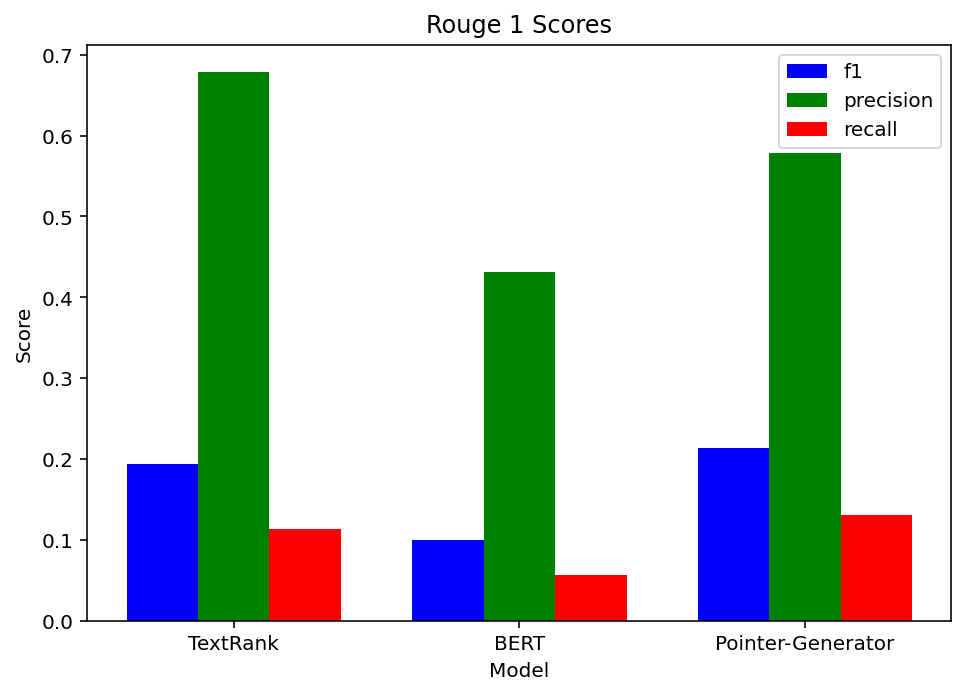

In [0]:
import numpy as np
import matplotlib.pyplot as plt
data = [[0.19338422147479106, 0.099737530765426, 0.21307505752956285],
[0.6785714285714286, 0.4318181818181818, 0.5789473684210527],
[0.11275964391691394, 0.05637982195845697, 0.13056379821958458]]
X = np.arange(3)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, data[0], color = 'b', width = 0.25, label = 'f1')
ax.bar(X + 0.25, data[1], color = 'g', width = 0.25, label = 'precision')
ax.bar(X + 0.50, data[2], color = 'r', width = 0.25, label = 'recall')

plt.xticks(np.arange(min(X)+0.25, max(X)+1, 1.0))
labels = [item.get_text() for item in ax.get_xticklabels()]
labels[0] = 'TextRank'
labels[1] = 'BERT'
labels[2] = 'Pointer-Generator'
ax.set_xticklabels(labels)
ax.legend()
plt.title('Rouge 1 Scores')
plt.ylabel('Score')
plt.xlabel('Model')
plt.show()

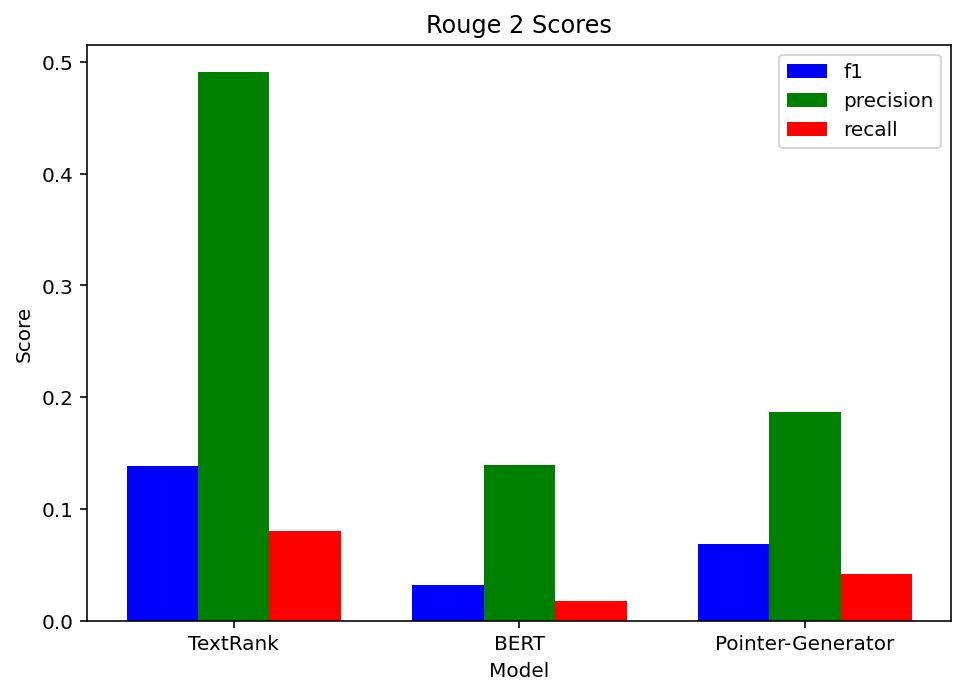

In [0]:
data = [[0.13810741446222882, 0.03166226711760583,0.0681265176976221],
[0.4909090909090909, 0.13953488372093023, 0.18666666666666668],
[0.08035714285714286, 0.017857142857142856, 0.041666666666666664]]
X = np.arange(3)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, data[0], color = 'b', width = 0.25, label = 'f1')
ax.bar(X + 0.25, data[1], color = 'g', width = 0.25, label = 'precision')
ax.bar(X + 0.50, data[2], color = 'r', width = 0.25, label = 'recall')
plt.xticks(np.arange(min(X)+0.25, max(X)+1, 1.0))
labels = [item.get_text() for item in ax.get_xticklabels()]
labels[0] = 'TextRank'
labels[1] = 'BERT'
labels[2] = 'Pointer-Generator'
ax.set_xticklabels(labels)
ax.legend()
plt.title('Rouge 2 Scores')
plt.ylabel('Score')
plt.xlabel('Model')
plt.show()

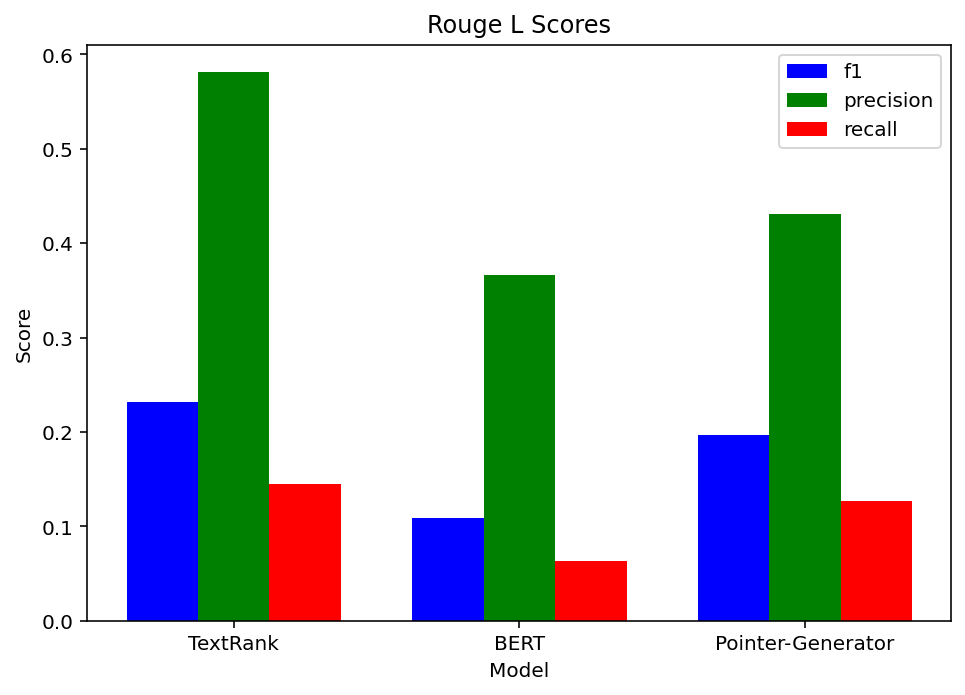

In [0]:
data = [[0.2314814782926098, 0.10837438171758602,0.19642856791175067],
[0.5813953488372093, 0.36666666666666664, 0.43137254901960786],
[0.14450867052023122, 0.06358381502890173,0.12716763005780346]]
X = np.arange(3)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, data[0], color = 'b', width = 0.25, label = 'f1')
ax.bar(X + 0.25, data[1], color = 'g', width = 0.25, label = 'precision')
ax.bar(X + 0.50, data[2], color = 'r', width = 0.25, label = 'recall')
plt.xticks(np.arange(min(X)+0.25, max(X)+1, 1.0))
labels = [item.get_text() for item in ax.get_xticklabels()]
labels[0] = 'TextRank'
labels[1] = 'BERT'
labels[2] = 'Pointer-Generator'

ax.set_xticklabels(labels)
ax.legend()
plt.title('Rouge L Scores')
plt.ylabel('Score')
plt.xlabel('Model')
plt.show()

Pointer-Generator has the best Rouge 1 scores while TextRank has the best Rouge 2 and Rouge L scores. This makes sense as TextRank copies sentences directly from the text, so it is more likely that it will have overlapping bigrams with the 3rd party headnote as they likely took bigrams directly from the text. The same goes for the Rouge L scores as TextRank was the only extractive model so it is much more likely that TextRank will have the longest common subsequence of words with the headnotes as they likely took phrases directly from the original case text. Pointer-generator has the best Rouge 1 score as it does better at selecting words that overlap with the original text. This makes sense as our Pointer-Generator model isn't bound by the same inflexibility of an extractive model like TextRank, is longer than the BERT summary so it is more likely that it will contain overlapping words with the original text, and it has coverage so it is incentivized to avoid repetitive words and thus cover more topics within the original text. 

# Conclusion
Based upon the comparison of our summarizations with the 3rd party generated headnote, it appears that the pointer-generator with coverage model does the best. This model improves upon the TextRank model because it is able to convey more information about the case and has more flexibility in how it chooses to summarize the very lengthy case law text. It improves upon the sequence-to-sequence with attention model because it fixes the problem of repetition that we witnessed. And lastly, it improves upon the BERT transformer because it contains the same information but includes even more potentially relevant details, like the dates and how 'ratley requested a trial de novo', which was included in the 3rd party generated headnote as well and seems to be a significant detail to include. This model is able to concisely list the parties of the case and the basic findings of the case. The only problem with this model in comparision with the 3rd party headnotes is that we do not get very much information about the facts of the case. For example, the pointer-generator model doesn't summarize that the parties went to trial because of a claim involving fraud. This is nontrivial to provide a full understanding of the case. Thus, although we believe our chosen model, the pointer-generator model, does better than the 3rd party headnotes at concisely summarizing the parties, dates, and findings of the case, it could be improved by being able to include more information about the facts of the case that are relevant. 

In the future, we could work to improve upon our chosen model by training our model on the case laws, rather than on the CNN/Daily Mail data that the model was trained on. We believe the data set is large enough to where the model would be able to produce desirable results if we were to train directly on it. We considered doing this, but due to computation constraints, we decided against it. In addition, incorporating the 3rd party headnotes as a target class would hopefully improve the quality of the headnotes generated. 

Overall, we were able to achieve our goal of producing headnotes that are comparable to the ones generated by an independent company. While there are improvements that we can make in the future, we believe this is a great foundation for generating informative headnotes.